In [172]:
import pandas as pd
import numpy as np
import json
import joblib
import pickle

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
import seaborn as sns
from matplotlib.colors import to_hex
from matplotlib import cm
style.use("fivethirtyeight")

import statistics
import scipy
from scipy import stats
from scipy.stats import kruskal

import re
from collections import Counter
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.util import ngrams
import string

import sklearn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.base import BaseEstimator, TransformerMixin

# 1. Introdução
- Este documento apresenta os resultados e discussões do projeto "Análise e Previsão de notas do IMDb" conduzido pela Indicium, contratada pelo estúdio de Hollywood PProductions.
- Este projeto está dividido em duas partes:
  - Análise do banco de dados cinematográficos disponibilizado, destacando questões gerais e específicas de negócio;
  - Construção de um modelo preditivo das notas do IMDb e análise do seu desempenho.
- Este projeto vai ajudar o cliente no processo de tomada de decisões, principalmente em relação ao investimento em novas produções artísticas e em previsões de notas do IMDb, como solicitado pelo cliente.


## Contexto das avaliações do IMDB (Internet Movie Database)
- Para o entendimento do negócio e do contexto dos dados, primeiramente foi realizada uma pesquisa sobre o IMDb e o seu método de calcular as avaliações das obras.
- Sobre o IMDb: De acordo com o próprio site da empresa [[1]](https://www.imdb.com/pressroom/about/), que faz parte da Amazon, é a mais popular e confiável fonte de informação sobre filmes, programas de televisão e celebridades. Centenas de milhões de usuários utilizam os seus serviços para decidir o que consumir, avançar em suas carreiras profissionais no ramo do entretenimento, ou para melhorar os seus negócios, utilizando os seus dados para obter percepções de tendências. O que se mostra muito adequado o uso destes dados neste projeto, de acordo com os requisitos do cliente.
- Sobre o cálculo das avalições das obras: Ainda utilizando o site oficial do IMDB como fonte [[2]](https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV?showReportContentLink=true&reportContentLinkPath=%2Fcontact%2Freport#), foi constatado que as notas variam entre 0 a 10, eles utilizam uma média ponderada baseada na atividade de avaliações do usuário, para maior confiabilidade do sistema. Afim de evitar manipulações (como avaliações massivas), o método exato do cálculo das notas não é divulgado. Segundo a empresa, a fórmula é consistente, sem viés, e calculada automaticamente, sem intervenção humana. Eles também não coletam ou consideram fatores externos, apesar de oferecerem links apra avaliações críticas e também disponibilizarem o Metascore (outro sistema de avaliação, do Metacritic). O mínimo de avaliações de uma obra para uma nota é 5.


# 2. Limpeza de Dados




- Nesta etapa, primeiramente foi realizada uma análise de entendimento dos dados,  com o objetivo de identificar o significado, tipo e estrutura de cada coluna da base disponibilizada.
- Também foram identificados pontos para fazer a limpeza e padronização os dados, para prepará-los para a análise exploratória e modelagem.

In [173]:
# Carregamento dos dados disponibilizados
df = pd.read_csv('desafio_indicium_imdb.csv')

# Visualização das primeiras linhas
df.head()

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


In [174]:
# Verificação da quantidade de linhas e colunas do dataset
print(df.shape)

(999, 16)


In [175]:
# Verificação das colunas, valores não nulos e tipos dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


In [176]:
# Verificação de entradas duplicadas
df.duplicated().sum()

np.int64(0)

- Nesta primeira parte, foram verificadas características gerais dos dados, como número total de linhas e de colunas, tipos de dados, valores não nulos e duplicados.
- Foi verificado que as colunas 'Certificate' (cerca de 10.1%), ' Gross' (cerca de 16.9%) e 'Meta_score' (cerca de 15.7%) possuem dados faltantes.
- Em seguida, foi realizadas análises e limpezas de colunas específicas do conjunto de dados.

In [177]:
# Eliminar Coluna 'Unnamed: 0'
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  999 non-null    object 
 2   Certificate    898 non-null    object 
 3   Runtime        999 non-null    object 
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non-null    object 
 7   Meta_score     842 non-null    float64
 8   Director       999 non-null    object 
 9   Star1          999 non-null    object 
 10  Star2          999 non-null    object 
 11  Star3          999 non-null    object 
 12  Star4          999 non-null    object 
 13  No_of_Votes    999 non-null    int64  
 14  Gross          830 non-null    object 
dtypes: float64(2), int64(1), object(12)
memory usage: 117.2+ KB


In [178]:
# Verificação da contagem de entradas únicas da coluna 'Genre'
df['Certificate'].value_counts()

,count
Certificate,
U,234
A,196
UA,175
R,146
PG-13,43
PG,37
Passed,34
G,12
Approved,11


- A coluna 'Certificate', com as classificações indicativas das obras possui 16 categorias, e, para enteder o significado de cada uma delas, foi foi realizada uma pesquisa em dados externos:
  - De acordo com o site do IMDb [[3]](https://help.imdb.com/article/contribution/titles/certificates/GU757M8ZJ9ZPXB39?ref_=helpms_helpart_inline#) e da Motion Picture Association (MPA) [[4]]((https://www.motionpictures.org/film-ratings/)), nos Estados Unidos são utilizadas estas categorias:
    - G, para todas as audiências;
    - PG, (Parental Guidance) para obras que precisam de orientação parental, geralmente para menores de 10 anos;
    - PG-13, para orientação parental para menores de 13 anos;
    - R em que menores de 17 anos não são admitidos sem a presença dos pais ou responsáveis;
    - NC-17, em que menores de 17 anos não são admitidos
    - Approved para títulos anteriores a 1968, quando se utilizava apenas 'Approved' ou 'Disapproved' como classificações indicativas.
  - Ademais, foram encontradas categorias de outros países, como Índia. De acordo com a CBFC Certification [[5]](https://www.cbfcindia.gov.in/cbfcAdmin/certification.php) são utilizadas as categorias:
    - U, para acesso irrestrito do público;
    - A, para adultos;
    - UA, para acesso irrestrito, mas sob orientação parental;
    - S, restrito para audiências especializadas;
  - As outras categorias abrengem filmes ainda não avaliados, como 'Not Rated' e 'Unrated' [[6]](https://en.wikipedia.org/wiki/Motion_Picture_Association_film_rating_system) e também classificações indicativas específicas para televisão [[7]](https://web.archive.org/web/20130731000958/http://www.tvguidelines.org/ratings.htm):
    - TV-PG, em que orientação parental é sugerida;
    - TV-14, em que o conteúdo pode não ser apropriado para menores de 14 anos;
    - TV-MA (Mature Audience), sugerido apenas para adultos, não é apropriado para menores de 17 anos.
- Diante desta pesquisa dos significados das categorias desta coluna, foi decidido, a princípio, apenas padronizar algumas entradas que possuem o mesmo significado, pois, mesmo que algumas classificações indicativas dos dados tenham pouca representação, essas diferenças de país ou de meio de comunicação podem trazer algumas informações relevantes na análise.
- Os dados faltantes foram rotulados como 'unknown'.


In [179]:
# Uniformizar categorias e tratar dados faltantes
df['Certificate']=df['Certificate'].str.replace('GP', 'PG')
df['Certificate']=df['Certificate'].str.replace('U/A', 'UA')
df['Certificate']=df['Certificate'].str.replace('Unrated', 'unknown')
df['Certificate']=df['Certificate'].fillna('unknown')
df['Certificate'].value_counts()

,count
Certificate,
U,234
A,196
UA,176
R,146
unknown,102
PG-13,43
PG,39
Passed,34
G,12


In [180]:
# Verificação dos valores únicos da coluna 'Released_Year'
print(f'Quantidade de valores únicos em Released_Year:  ' , len(df.Released_Year.unique()))
print('*' * 30)
df.Released_Year.unique()

Quantidade de valores únicos em Released_Year:   100
******************************


array(['1972', '2008', '1974', '1957', '2003', '1994', '1993', '2010',
       '1999', '2001', '1966', '2002', '1990', '1980', '1975', '2020',
       '2019', '2014', '1998', '1997', '1995', '1991', '1977', '1962',
       '1954', '1946', '2011', '2006', '2000', '1988', '1985', '1968',
       '1960', '1942', '1936', '1931', '2018', '2017', '2016', '2012',
       '2009', '2007', '1984', '1981', '1979', '1971', '1963', '1964',
       '1950', '1940', '2013', '2005', '2004', '1992', '1987', '1986',
       '1983', '1976', '1973', '1965', '1959', '1958', '1952', '1948',
       '1944', '1941', '1927', '1921', '2015', '1996', '1989', '1978',
       '1961', '1955', '1953', '1925', '1924', '1982', '1967', '1951',
       '1949', '1939', '1937', '1934', '1928', '1926', '1920', '1970',
       '1969', '1956', '1947', '1945', '1930', '1938', '1935', '1933',
       '1932', '1922', '1943', 'PG'], dtype=object)

In [181]:
# Verificação da linha com o ano errado
df[df['Released_Year'] == 'PG']

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
965,Apollo 13,PG,U,140 min,"Adventure, Drama, History",7.6,NASA must devise a strategy to return Apollo 1...,77.0,Ron Howard,Tom Hanks,Bill Paxton,Kevin Bacon,Gary Sinise,269197,"173,837,933"


- Na coluna 'Released_Year', só foi realizado uma correção em uma linha, que tinha uma entrada errada, 'PG' ao invés do ano correspondente ao filme. Provavelmente um erro na hora de preencher os dados. Essa falha foi corrigida manualmente ao conferir a data de lançamento do filme 'Apollo 13' no site do IMDb [[8]](https://www.imdb.com/title/tt0112384/?ref_=fn_all_ttl_1)

In [182]:
# Correção da entrada errada para o filme Apollo 13
df['Released_Year']=df['Released_Year'].replace('PG', '1995')
print(f'Valores únicos em Released_Year:  ' , len(df.Released_Year.unique()))
print('*' * 30)
print(df.Released_Year.unique())
print(df.Released_Year.value_counts())

Valores únicos em Released_Year:   99
******************************
['1972' '2008' '1974' '1957' '2003' '1994' '1993' '2010' '1999' '2001'
 '1966' '2002' '1990' '1980' '1975' '2020' '2019' '2014' '1998' '1997'
 '1995' '1991' '1977' '1962' '1954' '1946' '2011' '2006' '2000' '1988'
 '1985' '1968' '1960' '1942' '1936' '1931' '2018' '2017' '2016' '2012'
 '2009' '2007' '1984' '1981' '1979' '1971' '1963' '1964' '1950' '1940'
 '2013' '2005' '2004' '1992' '1987' '1986' '1983' '1976' '1973' '1965'
 '1959' '1958' '1952' '1948' '1944' '1941' '1927' '1921' '2015' '1996'
 '1989' '1978' '1961' '1955' '1953' '1925' '1924' '1982' '1967' '1951'
 '1949' '1939' '1937' '1934' '1928' '1926' '1920' '1970' '1969' '1956'
 '1947' '1945' '1930' '1938' '1935' '1933' '1932' '1922' '1943']
Released_Year
2014    32
2004    31
2009    29
2016    28
2013    28
        ..
1920     1
1926     1
1930     1
1922     1
1943     1
Name: count, Length: 99, dtype: int64


In [183]:
# Verificação de valores únicos nas colunas 'Director', 'Star1', 'Star2', 'Star3' e 'Star4'
print(f'Valores únicos em Director :  ' , len(df.Director.unique()))
print(f'Valores únicos em Star1:  ' , len(df.Star1.unique()))
print(f'Valores únicos em Star2:  ' , len(df.Star2.unique()))
print(f'Valores únicos em Star3:  ' , len(df.Star3.unique()))
print(f'Valores únicos em Star4:  ' , len(df.Star4.unique()))

Valores únicos em Director :   548
Valores únicos em Star1:   659
Valores únicos em Star2:   840
Valores únicos em Star3:   890
Valores únicos em Star4:   938


- Nestas colunas, foi verificada a alta quantidade de valores únicos, o que pode dificultar a sua análise e inclusão no modelo de previsão.

In [184]:
# Verificação de valores únicos na coluna 'Runtime'
print(f'Valores únicos em Runtime:  ' , len(df.Runtime.unique()))
print('*' * 30)
print(df.Runtime.unique())
print(df.Runtime.value_counts())

Valores únicos em Runtime:   140
******************************
['175 min' '152 min' '202 min' '96 min' '201 min' '154 min' '195 min'
 '148 min' '139 min' '178 min' '142 min' '161 min' '179 min' '136 min'
 '146 min' '124 min' '133 min' '160 min' '132 min' '153 min' '169 min'
 '130 min' '125 min' '189 min' '116 min' '127 min' '118 min' '121 min'
 '207 min' '122 min' '106 min' '112 min' '151 min' '150 min' '155 min'
 '119 min' '110 min' '88 min' '137 min' '89 min' '165 min' '109 min'
 '102 min' '87 min' '126 min' '147 min' '117 min' '181 min' '149 min'
 '105 min' '164 min' '170 min' '98 min' '101 min' '113 min' '134 min'
 '229 min' '115 min' '143 min' '95 min' '104 min' '123 min' '131 min'
 '108 min' '81 min' '99 min' '114 min' '129 min' '228 min' '128 min'
 '103 min' '107 min' '68 min' '138 min' '156 min' '167 min' '163 min'
 '186 min' '321 min' '135 min' '140 min' '180 min' '158 min' '210 min'
 '86 min' '162 min' '177 min' '204 min' '91 min' '172 min' '45 min'
 '145 min' '100 min' '196

- Para esta coluna, a única limpeza necessária foi remover as indicações de minutos, para torná-la exclusivamente numérica.

In [185]:
# Limpeza da coluna 'Runtime'
df['Runtime (min)']=df['Runtime'].str.replace(' min', '')
print(f'Unique runtime is :  ' , len(df['Runtime (min)'].unique()))
print('*' * 30)
print(df['Runtime (min)'].unique())

Unique runtime is :   140
******************************
['175' '152' '202' '96' '201' '154' '195' '148' '139' '178' '142' '161'
 '179' '136' '146' '124' '133' '160' '132' '153' '169' '130' '125' '189'
 '116' '127' '118' '121' '207' '122' '106' '112' '151' '150' '155' '119'
 '110' '88' '137' '89' '165' '109' '102' '87' '126' '147' '117' '181'
 '149' '105' '164' '170' '98' '101' '113' '134' '229' '115' '143' '95'
 '104' '123' '131' '108' '81' '99' '114' '129' '228' '128' '103' '107'
 '68' '138' '156' '167' '163' '186' '321' '135' '140' '180' '158' '210'
 '86' '162' '177' '204' '91' '172' '45' '145' '100' '196' '93' '120' '92'
 '144' '80' '183' '111' '141' '224' '171' '188' '94' '185' '85' '205'
 '212' '238' '72' '67' '76' '159' '83' '90' '84' '191' '197' '174' '97'
 '75' '157' '209' '82' '220' '64' '184' '168' '166' '192' '194' '193' '69'
 '70' '242' '79' '71' '78']


- Para a coluna 'Gross', as vírgulas foram retiradas, deixando apenas os números.

In [186]:
# Limpeza da coluna 'Gross' ao remover as vírgulas
df['Gross']=df['Gross'].str.replace(',', '')
df.head(1)

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Runtime (min)
0,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411,175


In [187]:
# Verificação da contagem de entradas únicas da coluna 'Genre'
df['Genre'].value_counts()

,count
Genre,
Drama,84
"Drama, Romance",37
"Comedy, Drama",35
"Comedy, Drama, Romance",31
"Action, Crime, Drama",30
...,...
"Action, Adventure, Family",1
"Action, Crime, Mystery",1
"Animation, Drama, Romance",1


- Esta coluna possui 202 valores únicos, com diferentes combinações dos gêneros das obras cinematográficas.
- Como a maioria dos filmes possuem mais do que um gênero, utilizar o método ".explode()" ou o "get_dummies()" apenas criaria a nova coluna de gênero para a primeira opção na coluna, então, foi utilizado o MultiLabelBinarizer, ferramenta de pré-processamento da biblioteca scikit-learn. Este transformador converte uma lista ou tupla em uma matriz binária (amostras x classes) indicando a presença de um rótulo de classe [[9]](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html).
- O primeiro passo foi criar listas com as entradas da coluna, em seguida, o MultiLabelBinarizer foi instanciado e aplicado à coluna de gênero, então foi criado o dataframe com as novas ccolunas e concatenado ao dataset original. Também foi criado um array com todos os 21 gêneros disponíveis.
- O código desta etapa de limpeza foi adaptado [deste tutorial [10]](https://medium.com/@mloyfer/exploring-sklearn-multilabel-binarizer-a000dec9784).

In [188]:
# Criar a coluna 'Genre_list'
df['Genre_list'] = df['Genre'].str.split(', ')
df['Genre_list']

,Genre_list
0,"[Crime, Drama]"
1,"[Action, Crime, Drama]"
2,"[Crime, Drama]"
3,"[Crime, Drama]"
4,"[Action, Adventure, Drama]"
...,...
994,"[Comedy, Drama, Romance]"
995,"[Drama, Western]"
996,"[Drama, Romance, War]"
997,"[Drama, War]"


In [189]:
# Instanciar o transformador, aplicar à coluna com as listas dos gêneros e salvar o array com os nomes
mlb = MultiLabelBinarizer()

mlb.fit_transform(df['Genre_list'])
genres = mlb.classes_
genres

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport',
       'Thriller', 'War', 'Western'], dtype=object)

In [190]:
# Criar df com colunas de gêneros
df_genres = pd.DataFrame(mlb.fit_transform(df['Genre_list']), columns=mlb.classes_, index=df.index)

# Concatenar ao dataset
df_cleaned = pd.concat([df, df_genres], axis=1)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  999 non-null    object 
 2   Certificate    999 non-null    object 
 3   Runtime        999 non-null    object 
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non-null    object 
 7   Meta_score     842 non-null    float64
 8   Director       999 non-null    object 
 9   Star1          999 non-null    object 
 10  Star2          999 non-null    object 
 11  Star3          999 non-null    object 
 12  Star4          999 non-null    object 
 13  No_of_Votes    999 non-null    int64  
 14  Gross          830 non-null    object 
 15  Runtime (min)  999 non-null    object 
 16  Genre_list     999 non-null    object 
 17  Action         999 non-null    int64  
 18  Adventure 

In [191]:
# Conferir contagens dos diferentes gêneros
for genre in genres:
  print(f'{genre}', df_cleaned[genre].sum())

Action 189
Adventure 196
Animation 82
Biography 109
Comedy 233
Crime 209
Drama 723
Family 56
Fantasy 66
Film-Noir 19
History 56
Horror 32
Music 35
Musical 17
Mystery 99
Romance 125
Sci-Fi 67
Sport 19
Thriller 137
War 51
Western 20


- Foi notado que alguns gêneros têm menos representação do que outros, como 'Sport', 'Western', 'Horror' e 'Music'. Isto pode influenciar a análise e modelagem.

- Para o tratamento dos dados da coluna 'Overview' com as descrições dos filmes, com os seguintes passos:
  - Carregamento dos 'stopwords' (palavras sem muito significado semântico, como pronomes e artigos) em inglês da biblioteca NLTK;
  - Aplicação do tokenizer, que separa as strings em substrings [[11]](https://github.com/LDSSA/batch7-students/blob/main/S04%20-%20Text%20Classification/BLU07%20-%20Feature%20Extraction/Learning%20notebook%20-%20Part%201%20of%203%20-%20Preprocessing%20for%20NLP.ipynb);
  - Aplicação do stemmer (do tipo Snowball), que permite obter a "raiz" das palavras ignorando sufixos;
  - Função para limpar as colunas de texto com as etapas:
    - Transformar tudo em minúsculo;
    - Tokenizar o texto;
    - Remover stopwords e pontuação;
    - Aplicar o stemmer;
    - Voltar a reunir as palavras em uma string
- Com estas transformações, o texto fica pronto para ser utilizado para as análises, juntamente com técnicas como bag-of-words, counter ou TF-IDF.
- Esta função foi adaptada do tutorial de NLP do Lisbon Data Science Academy [[12]](https://github.com/LDSSA/batch7-students/blob/df0aa60428d658bd0f7532ffd02bb773197ec9ba/S04%20-%20Text%20Classification/BLU07%20-%20Feature%20Extraction/Learning%20notebook%20-%20Part%203%20of%203%20-%20Sentiment%20analysis.ipynb) e do projeto "Yelp - Análise do estado do Tennessee" [[13]](https://github.com/ana0212/Yelp---Analise-do-estado-do-Tennessee/blob/main/Notebook%20-%20Yelp%20-%20An%C3%A1lise%20do%20estado%20do%20Tennessee.ipynb)

In [192]:
nltk.download('stopwords')

# Carregar stopwords do NLTK
stop_words = set(stopwords.words('english'))

# Aplicar o Tokenizer
tokenizer = WordPunctTokenizer()

# Aplicar o stemmer
stemmer = SnowballStemmer("english", ignore_stopwords=True)

# Função para limpar colunas de texto
def clean_text(doc):
    # Transformar em lowercase
    doc = doc.lower()

    # Tokenizar o texto
    words = tokenizer.tokenize(doc)

    # Remover pontuação e stopwords
    words = [word for word in words if word not in string.punctuation and word not in stop_words]

    # Aplicar stemming
    stems = [stemmer.stem(word) for word in words]

    # Reunir as palavras em uma string
    clean_text = " ".join(stems)

    return clean_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [193]:
# Aplicar a função de limpeza e verificar o resultado
df_cleaned['Overview'] = df_cleaned['Overview'].apply(clean_text)
df_cleaned['Overview'].head(10)

,Overview
0,organ crime dynasti age patriarch transfer con...
1,menac known joker wreak havoc chao peopl gotha...
2,earli life career vito corleon 1920s new york ...
3,juri holdout attempt prevent miscarriag justic...
4,gandalf aragorn lead world men sauron armi dra...
5,live two mob hitmen boxer gangster wife pair d...
6,german occupi poland world war ii industrialis...
7,thief steal corpor secret use dream share tech...
8,insomniac offic worker devil may care soapmak ...
9,meek hobbit shire eight companion set journey ...


- Por último, foi feita a retificação dos tipos de dados de algumas colunas.

In [194]:
df_cleaned[['Released_Year', 'Runtime (min)']] = df_cleaned[['Released_Year', 'Runtime (min)']].astype(int)
df_cleaned['Gross'] = df_cleaned['Gross'].astype(float)
df_cleaned['Certificate'] = df_cleaned['Certificate'].astype('category')
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Series_Title   999 non-null    object  
 1   Released_Year  999 non-null    int64   
 2   Certificate    999 non-null    category
 3   Runtime        999 non-null    object  
 4   Genre          999 non-null    object  
 5   IMDB_Rating    999 non-null    float64 
 6   Overview       999 non-null    object  
 7   Meta_score     842 non-null    float64 
 8   Director       999 non-null    object  
 9   Star1          999 non-null    object  
 10  Star2          999 non-null    object  
 11  Star3          999 non-null    object  
 12  Star4          999 non-null    object  
 13  No_of_Votes    999 non-null    int64   
 14  Gross          830 non-null    float64 
 15  Runtime (min)  999 non-null    int64   
 16  Genre_list     999 non-null    object  
 17  Action         999 non-null    int6

# 3. Análise Exploratória (EDA)

## 3.1 Questões Gerais
-  Nesta seção, foram analisados os aspectos gerais do conjunto de dados com o objetivo de investigar as principais características entre as variáveis e apresentar algumas hipóteses relacionadas.
- Foram utilizadas técnicas de estatística descritiva, inferencial e visualização de dados.
- Como solicitado pelo cliente, também foi investigado qual tipo de filme deve ser o próximo a ser desenvolvido.

- Na primeira etapa da EDA, foram analisadas descritivamente as variávais numéricas, para o entendimento de suas características e distribuições, principalmente a variável-alvo do modelo de previsão: 'IMDB_Rating'.

In [195]:
# Visualização dos principais dados descritivos das colunas numéricas
df_cleaned_num = ['Released_Year', 'Runtime (min)', 'IMDB_Rating', 'Meta_score', 'No_of_Votes', 'Gross']
df_cleaned[df_cleaned_num].describe().apply(lambda x: x.apply('{0:.3f}'.format))

,Released_Year,Runtime (min),IMDB_Rating,Meta_score,No_of_Votes,Gross
count,999.000,999.000,999.000,842.000,999.000,830.000
mean,1991.218,122.872,7.948,77.969,271621.422,68082574.105
std,23.297,28.101,0.272,12.383,320912.621,109807553.386
min,1920.000,45.000,7.600,28.000,25088.000,1305.000
25%,1976.000,103.000,7.700,70.000,55471.500,3245338.500
50%,1999.000,119.000,7.900,79.000,138356.000,23457439.500
75%,2009.000,137.000,8.100,87.000,373167.500,80876340.250
max,2020.000,321.000,9.200,100.000,2303232.000,936662225.000


In [196]:
# Calculando IQR da coluna 'IMDB_Rating'
Q1 = df_cleaned['IMDB_Rating'].quantile(0.25)
Q3 = df_cleaned['IMDB_Rating'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

# Identificando outliers da coluna 'IMDB_Rating'
imdb_outliers = df_cleaned[(df_cleaned['IMDB_Rating'] < (Q1 - 1.5*IQR)) | (df_cleaned['IMDB_Rating'] > (Q3 + 1.5*IQR))]
print(imdb_outliers[['Series_Title', 'IMDB_Rating']])
print(f'kurtose da coluna: {df_cleaned["IMDB_Rating"].kurtosis()}')
print(f'skewness da coluna: {df_cleaned["IMDB_Rating"].skew()}')

0.39999999999999947
                                         Series_Title  IMDB_Rating
0                                       The Godfather          9.2
1                                     The Dark Knight          9.0
2                              The Godfather: Part II          9.0
3                                        12 Angry Men          9.0
4       The Lord of the Rings: The Return of the King          8.9
5                                        Pulp Fiction          8.9
6                                    Schindler's List          8.9
7                                           Inception          8.8
8                                          Fight Club          8.8
9   The Lord of the Rings: The Fellowship of the Ring          8.8
10                                       Forrest Gump          8.8
11                    Il buono, il brutto, il cattivo          8.8
kurtose da coluna: 1.0583968003596653
skewness da coluna: 0.9466926905932237


- Apesar das avaliações do IMDb serem de 0.0 a 10.0, neste conjunto de dados abrange apenas o mínimo de 7.6 a 9.2. Também possui um desvio-padrão baixo, de 0.272. A média das avaliações dos filmes é de 7.948. Possui apenas 12 entradas consideradas outliers (1.2%), todos acima da média. Também tem kurtose e skewness positivos, a indicar que possui assimetria positiva e é do tipo leptocúrtica.
- Isso significa que os dados não são muito variados e a distribuição possui uma cauda a direita, o que pode ser um desafio ao treinar o modelo de previsão com valores em um espaço reduzido.

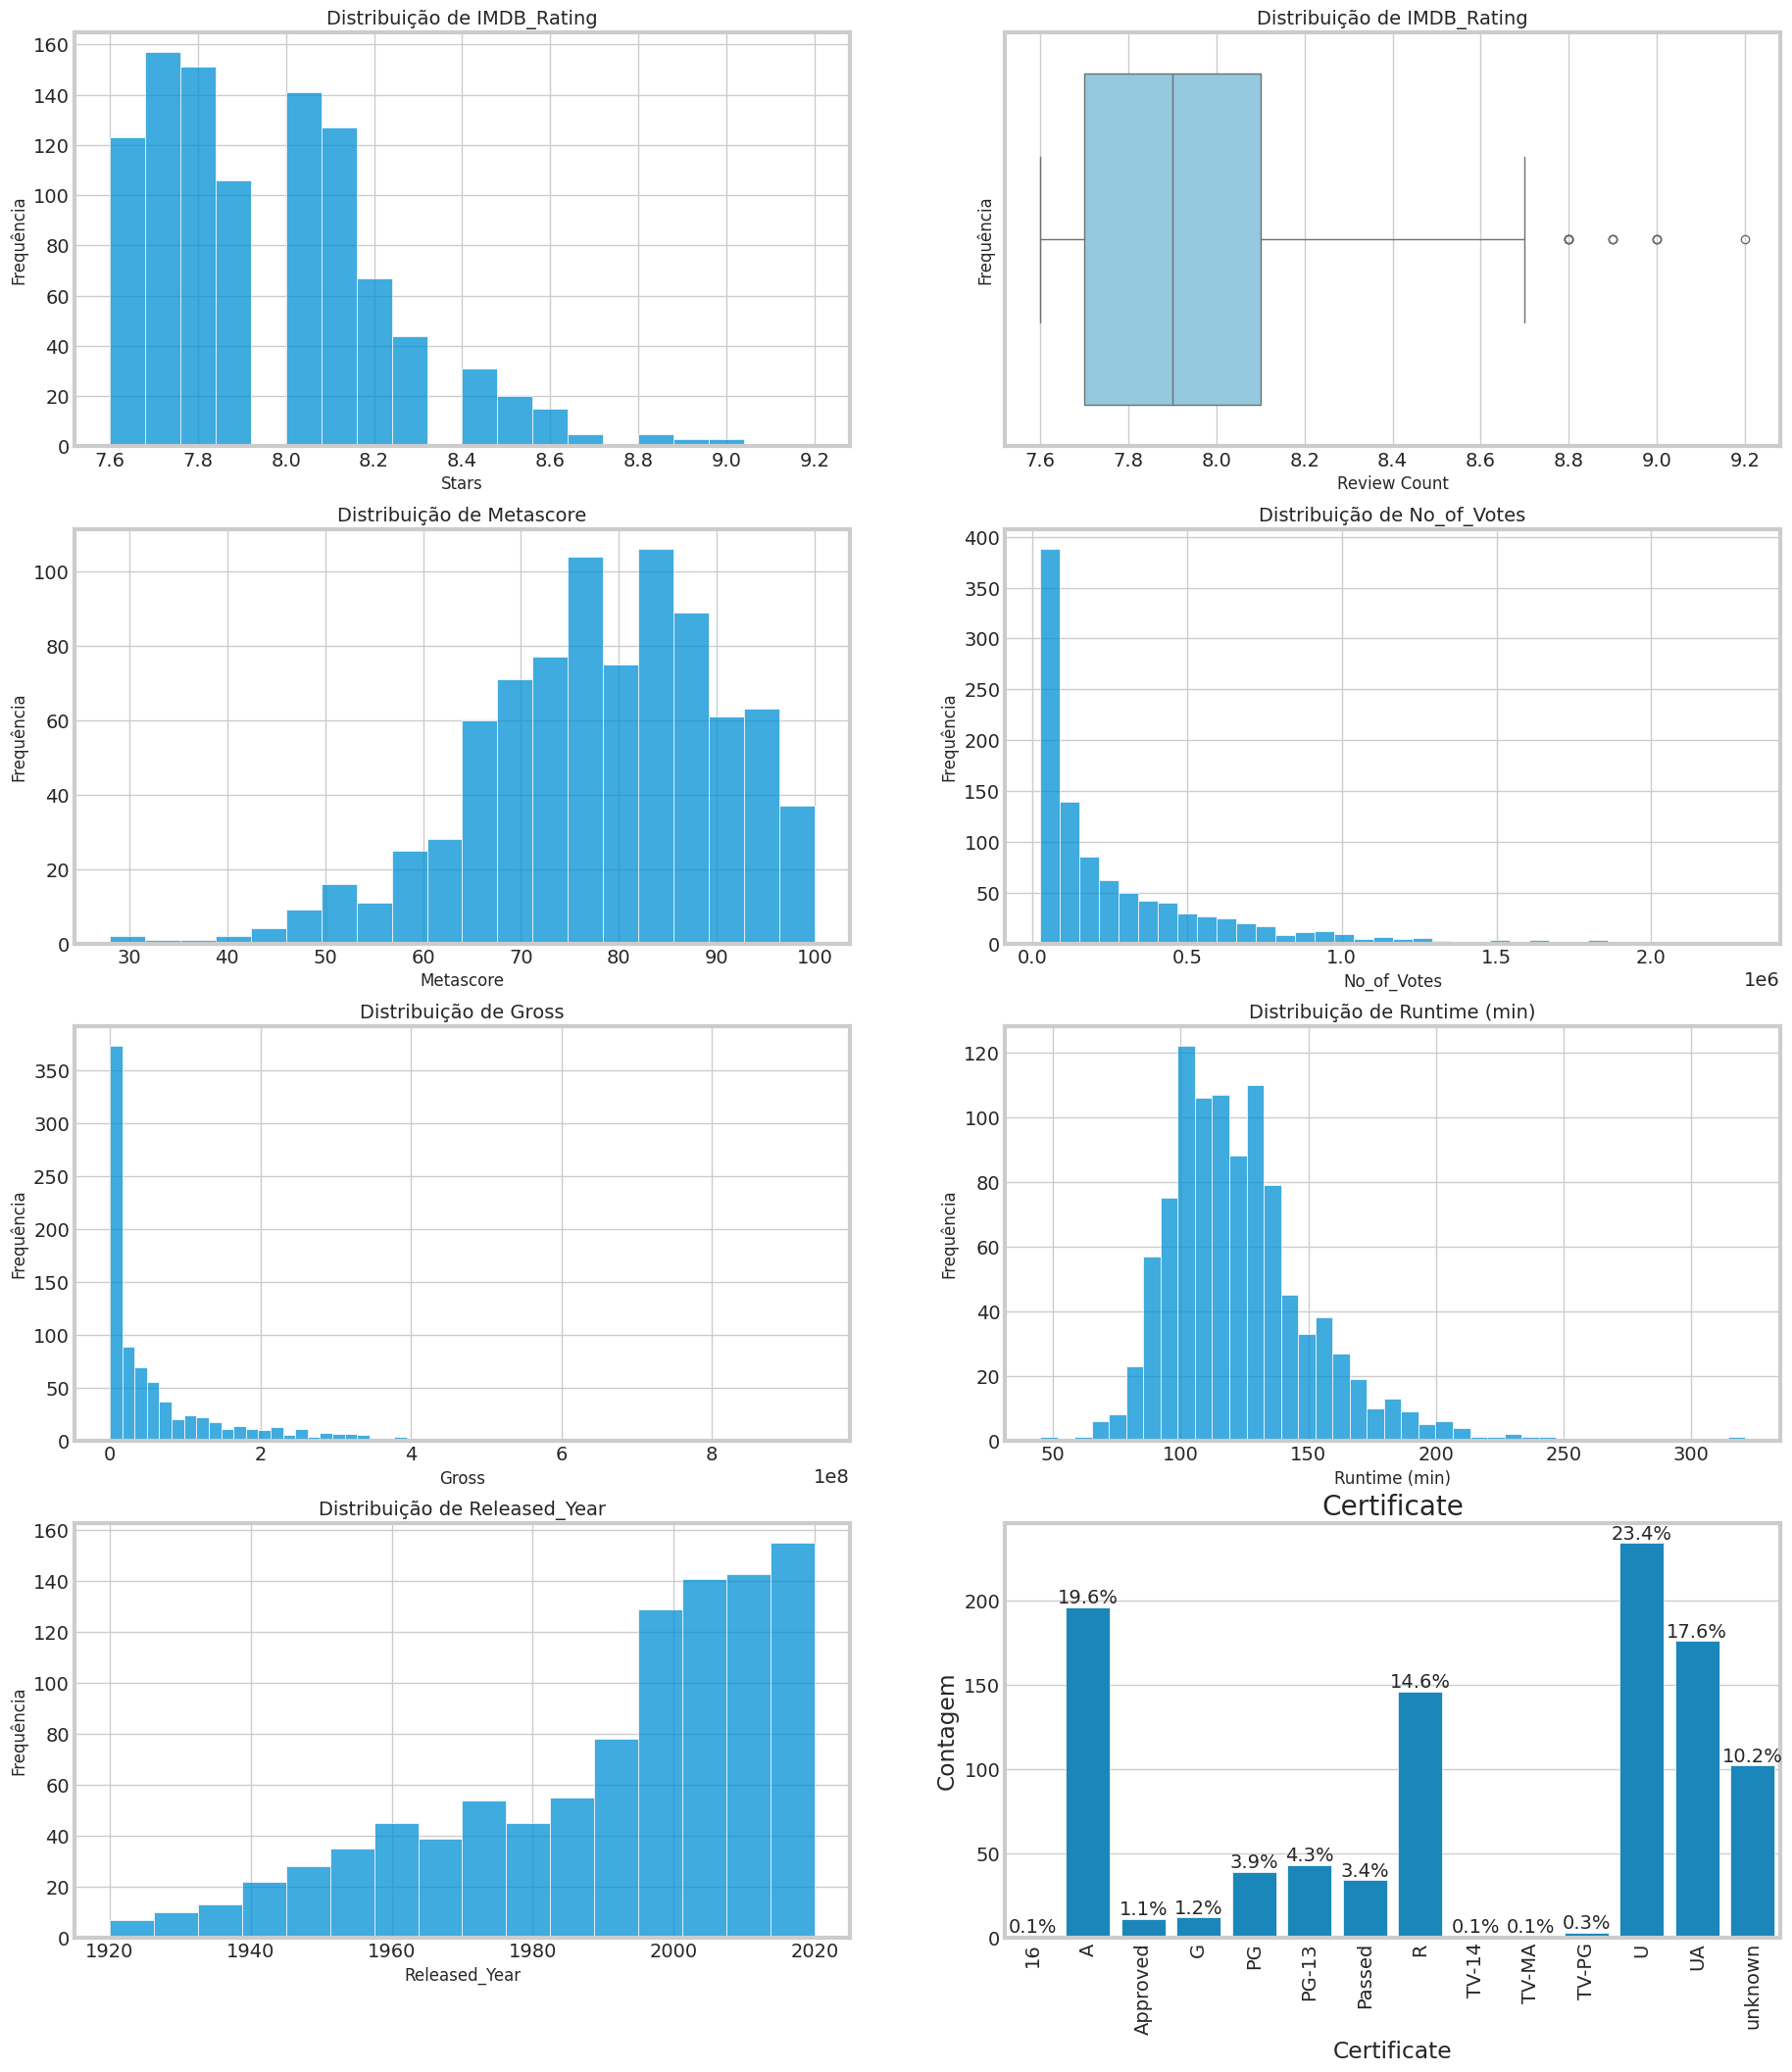

<Figure size 640x480 with 0 Axes>

In [132]:
# Ajuste de estilo para os gráficos
sns.set_style("whitegrid")
plt.figure(figsize=(20, 24))

# Histograma da coluna 'IMDB_Rating'
plt.subplot(4, 2, 1)
sns.histplot(df_cleaned['IMDB_Rating'])
plt.title('Distribuição de IMDB_Rating', fontsize=14)
plt.xlabel('Stars', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

# Gráfico de boxplot da coluna 'IMDB_Rating'
plt.subplot(4, 2, 2)
sns.boxplot(x=df_cleaned['IMDB_Rating'], color='skyblue')
plt.title('Distribuição de IMDB_Rating', fontsize=14)
plt.xlabel('Review Count', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

# Histograma da coluna 'Meta_score'
plt.subplot(4, 2, 3)
sns.histplot(df_cleaned['Meta_score'])
plt.title('Distribuição de Metascore', fontsize=14)
plt.xlabel('Metascore', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

# Histograma da coluna 'No_of_Votes'
plt.subplot(4, 2, 4)
sns.histplot(df_cleaned['No_of_Votes'])
plt.title('Distribuição de No_of_Votes', fontsize=14)
plt.xlabel('No_of_Votes', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

# Histograma da coluna 'Gross'
plt.subplot(4, 2, 5)
sns.histplot(df_cleaned['Gross'])
plt.title('Distribuição de Gross', fontsize=14)
plt.xlabel('Gross', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

# Histograma da coluna 'Runtime (min)'
plt.subplot(4, 2, 6)
sns.histplot(df_cleaned['Runtime (min)'])
plt.title('Distribuição de Runtime (min)', fontsize=14)
plt.xlabel('Runtime (min)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

# Histograma da coluna 'Released_Year'
plt.subplot(4, 2, 7)
sns.histplot(df_cleaned['Released_Year'])
plt.title('Distribuição de Released_Year', fontsize=14)
plt.xlabel('Released_Year', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

# Gráfico de barras da coluna 'Certificate'
plt.subplot(4, 2, 8)
ax = sns.countplot(data=df_cleaned, x='Certificate')
plt.title('Certificate')
plt.xticks(rotation=90)
plt.xlabel('Certificate')
plt.ylabel('Contagem')
# Adicionar porcentagens
total = len(df_cleaned)
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.text(p.get_x() + p.get_width() / 2., height, f'{percentage:.1f}%', ha='center', va='bottom')
plt.show()

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Mostrar o gráfico
plt.show()

- Em relação às outras variáveis:
  - 'Released_Year': possui dados entre 1920 e 2020. Metade dos filmes têm o ano de lançamento a partir de 1999, que indica um aumento da produção cinematográfica com a virada do século 2000.
  - 'Runtime (min)': sobre a duração em minutos dos filmes, ela abrange os valores de 45 a 321, com média de 122.872. O primeiro quartil é de 130 minutos e o terceiro quartil de 137 minutos, o que indica que a maioria dos filmes possuem duração de cerca de uma hora e meia e duas horas.
  - 'Meta_score': este tipo de avaliação possui abrangência entre 0 e 100, e, no conjunto de dados, entre 28 e 100, mais variado do que os valores do IMDb. Entretanto, também possui maior concentração entre 70 e 90.
  - 'No_of_Votes': A variável que representa o número de votos da plataforma possui um alto desvio-padrão (320912.621), maior do que a média (271621.422), possui uma alta assimetria postiva e uma distribuição que vai de 25088 a 2303232.
  - 'Gross': esta variável também possui uma distribuição assimétrica positiva, com valores que vão desde 1305 a 936662225. Seu desvio-padrão (109807553.386) também é superior à sua média (68082574.105).
- Também foram visualizadas as contagens das categorias da coluna 'Certificate', o sistema de classificaçã indicativa com 'U' (23.4%), 'UA' (17.6%) e 'A' (19.6%) é o mais frequente. As categorias menos frequentes são: TV-PG (0.3%), TV-MA (0.1%) e TV-14 (0.1%).

- Nesta segunda parte, o foco da análise foi investigar relações entre as variávies. Começando pela comparação de variáveis como 'No_of_Votes', 'Runtime (min)' 'Meta_score' e 'Gross' em relação ao ao ano de lançamento dos filmes, com o objetivo de analisar as tendências do mercado.

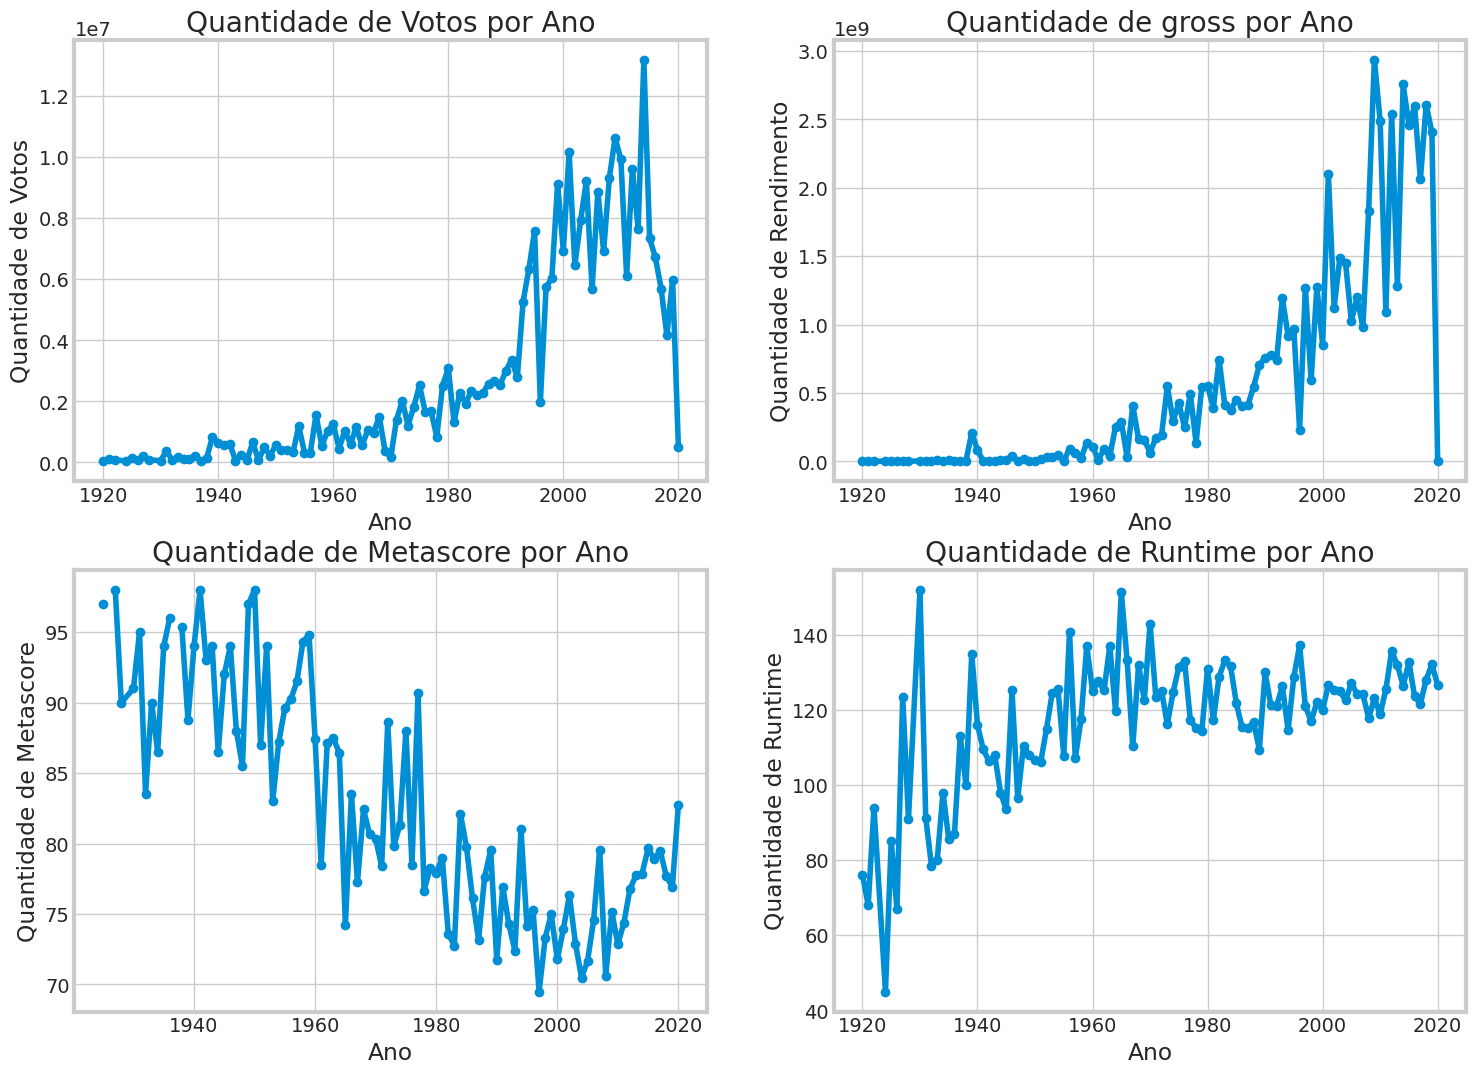

In [133]:
# Calcular a quantidade de votos, rendimento, metascore e runtime X Ano
votes_per_year = df_cleaned.groupby('Released_Year')['No_of_Votes'].sum().reset_index()
gross_per_year = df_cleaned.groupby('Released_Year')['Gross'].sum().reset_index()
metascore_per_year = df_cleaned.groupby('Released_Year')['Meta_score'].mean().reset_index()
runtime_per_year = df_cleaned.groupby('Released_Year')['Runtime (min)'].mean().reset_index()

plt.figure(figsize=(16, 12))

# Gráfico de Votos x Ano
plt.subplot(2, 2, 1)
plt.plot(votes_per_year['Released_Year'], votes_per_year['No_of_Votes'], marker='o')
plt.title('Quantidade de Votos por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Votos')
plt.grid(True)

# Gráfico de Rendimento x Ano
plt.subplot(2, 2, 2)
plt.plot(gross_per_year['Released_Year'], gross_per_year['Gross'], marker='o')
plt.title('Quantidade de gross por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Rendimento')
plt.grid(True)


# Gráfico de Metascore x Ano
plt.subplot(2, 2, 3)
plt.plot(metascore_per_year['Released_Year'], metascore_per_year['Meta_score'], marker='o')
plt.title('Quantidade de Metascore por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Metascore')
plt.grid(True)

# Gráfico de Runtime x Ano
plt.subplot(2, 2, 4)
plt.plot(runtime_per_year['Released_Year'], runtime_per_year['Runtime (min)'], marker='o')
plt.title('Quantidade de Runtime por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Runtime')
plt.grid(True)
plt.show()

- Diante destes gráficos, foi verificado uma alta na tendência do número dos votos e rendimento a partir dos anos 2000, indicando um crescimento do mercado cinematográfico, tanto em lucro quanto em popularidade.
- Entretanto, neste mesmo período, há uma tendência decrescente para o metascore desde 1920 a 2000, mas uma leve crescida a partir dos anos 2000. Que também pode indicar um crescimento do mercado, com filmes mais bem avaliados.
- Para a duração dos filmes ao longo dos anos, desde 1920 a 1960 foi notada uma tendência positiva, seguida de uma maior estabilidade entre os valores de 110 e 140. O que reforça o padrão já constatado na análise anterior.

- Em seguida, foram investigadas as relações entre as variáveis de gênero dos filmes (criadas na seção anterior com o MultinomialBinarizer) e outros fatores, como número de votos, rendimento e metascore. O objetivo foi identificar gêneros que se destacam nestes aspectos.
- Os gráficos a seguir representam as barras azuis representam as contagens totais de cada gênero (como total de votos, rendimento ou metascore) e a linha vermelha representa a média.

/tmp/ipython-input-1657738107.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)


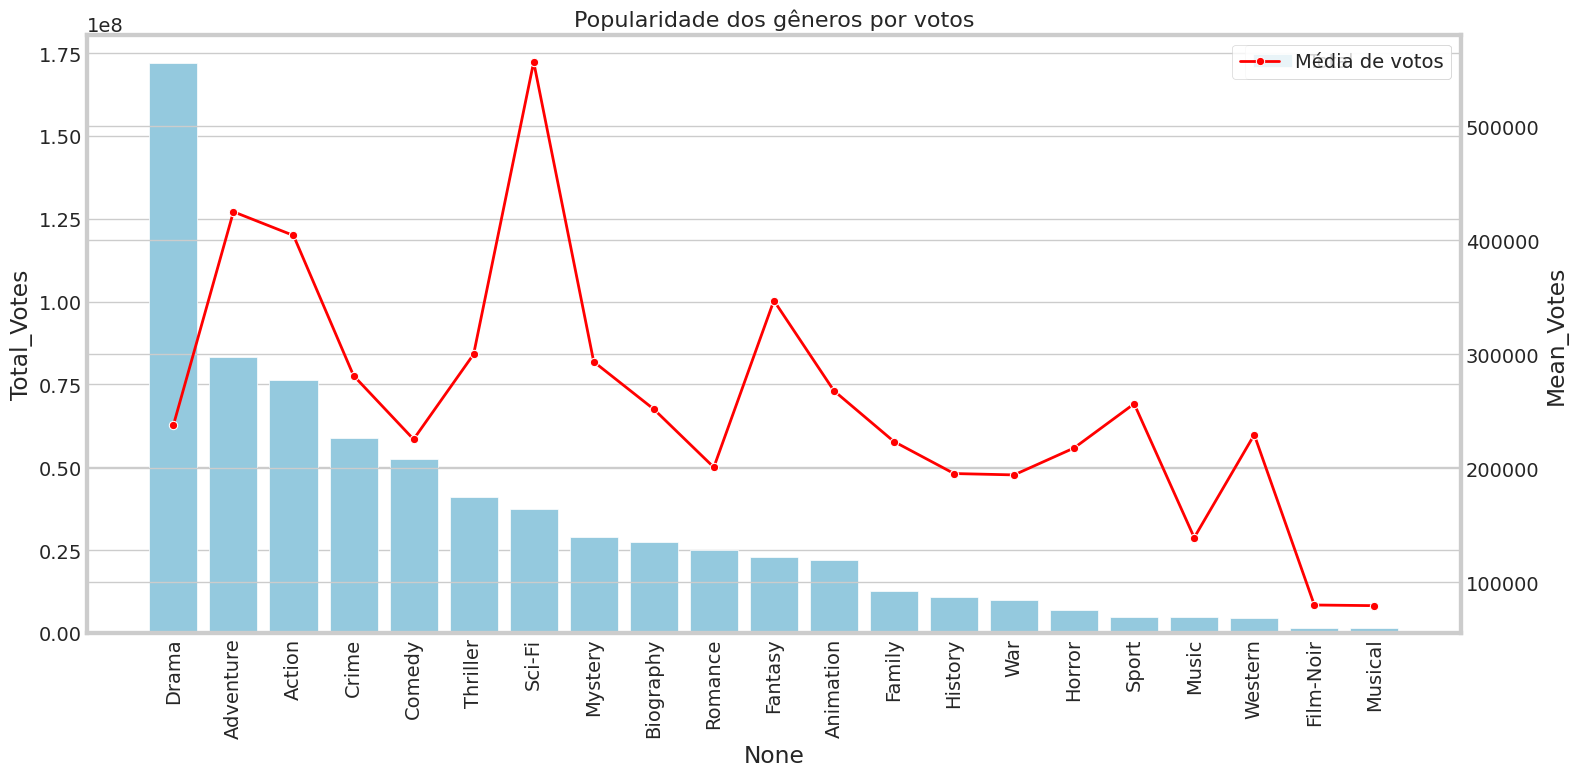

In [134]:
# Agrupamentos por gênero e número de votos
genre_cols = [col for col in df_cleaned.columns if col in genres]
votes_per_genre = (df_cleaned[genre_cols].T @ df_cleaned["No_of_Votes"])
movies_per_genre = df_cleaned[genre_cols].sum()
mean_votes_per_genre = votes_per_genre / movies_per_genre

# Organizando o DataFrame
genre_stats = pd.DataFrame({
    "Total_Votes": votes_per_genre,
    "Mean_Votes": mean_votes_per_genre,
    "Movies_Count": movies_per_genre
}).sort_values("Total_Votes", ascending=False)

# Gráfico
plt.figure(figsize=(16, 8))

# Gráfico de Barras com os totais
ax1 = sns.barplot(
    x=genre_stats.index,
    y="Total_Votes",
    data=genre_stats,
    color="skyblue",
    label="Total de votos"
)

# Gráfico de Linha com a média
ax2 = plt.twinx()
sns.lineplot(
    x=genre_stats.index,
    y="Mean_Votes",
    data=genre_stats,
    marker="o",
    color="red",
    linewidth=2,
    label="Média de votos",
    ax=ax2
)

plt.title("Popularidade dos gêneros por votos", fontsize=16)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
plt.tight_layout()

plt.show()

- Neste gráfico, é possível observar que o gênero 'Drama' possui maior contagem total de votos, mas a média de votos por filme não é tão alta. Já alguns gêneros possuem menor quantidade de votos no total, mas alta média de votos por filme, como 'Sci-fi' e 'Fantasy', indicando alto engajamento na plataforma.

/tmp/ipython-input-4004789092.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)


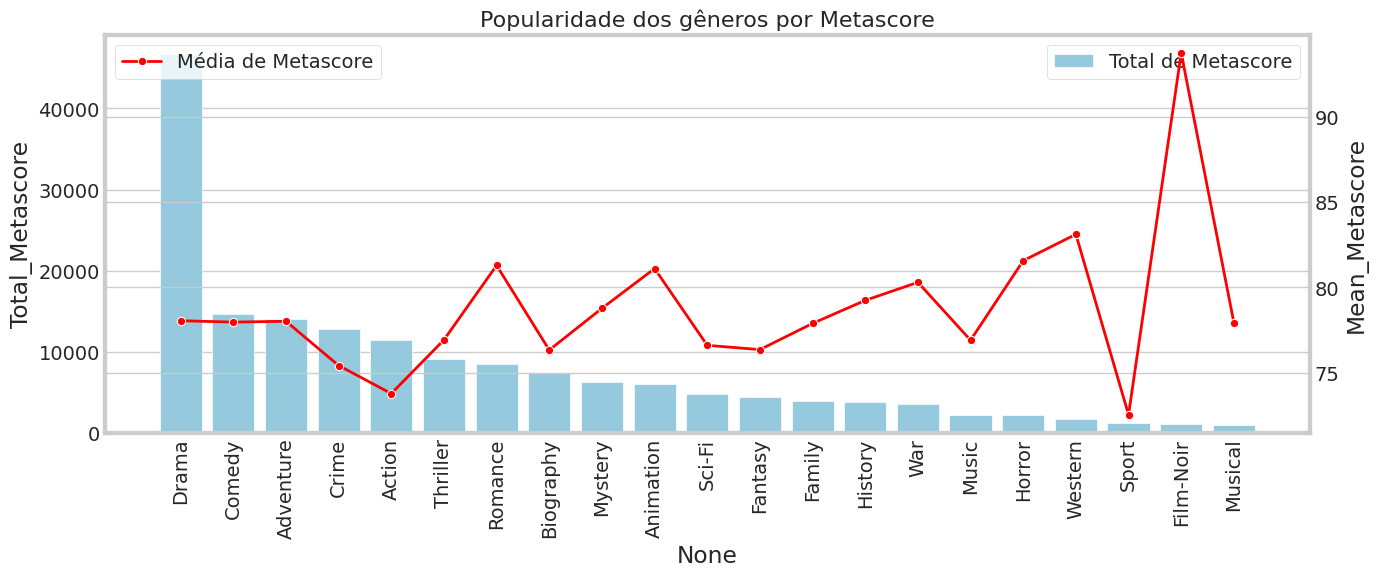

In [135]:
# Agrupamentos por gênero e metascore (devido aos valores faltantes desta coluna, foi feito um novo df sem estas linhas)
df_meta = df_cleaned.copy()
df_meta = df_meta.dropna(subset=['Meta_score'])
movies_per_genre_meta = df_meta[genre_cols].sum()
metascore_total = (df_meta[genre_cols].T @ df_meta["Meta_score"])
mean_metascore_per_genre = metascore_total / movies_per_genre_meta

# Organizando o DataFrame
genre_stats_metascore = pd.DataFrame({
    "Total_Metascore": metascore_total,
    "Mean_Metascore": mean_metascore_per_genre,
    "Movies_Count": movies_per_genre_meta
}).sort_values("Total_Metascore", ascending=False)

# Gráfico
plt.figure(figsize=(14,6))

# Gráfico de Barras com os totais
ax1 = sns.barplot(
    x=genre_stats_metascore.index,
    y="Total_Metascore",
    data=genre_stats_metascore,
    color="skyblue",
    label="Total de Metascore"
)

# Gráfico de Linha com a média
ax2 = plt.twinx()
sns.lineplot(
    x=genre_stats_metascore.index,
    y="Mean_Metascore",
    data=genre_stats_metascore,
    marker="o",
    color="red",
    linewidth=2,
    label="Média de Metascore",
    ax=ax2
)

# Títulos e legendas
plt.title("Popularidade dos gêneros por Metascore", fontsize=16)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
plt.tight_layout()

plt.show()

- Neste gráfico, é possível observar novamente que o gênero 'Drama' possui maior contagem total de votos, mas a média de metascore por filme não é tão alta. Assim como no gráfico anterior, alguns gêneros possuem menor quantidade de metascore no total, mas alta média nas avaliações por filme, como 'Film-Noir' e 'Western', indicando boa avaliação no Metascore.

/tmp/ipython-input-4016082833.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)


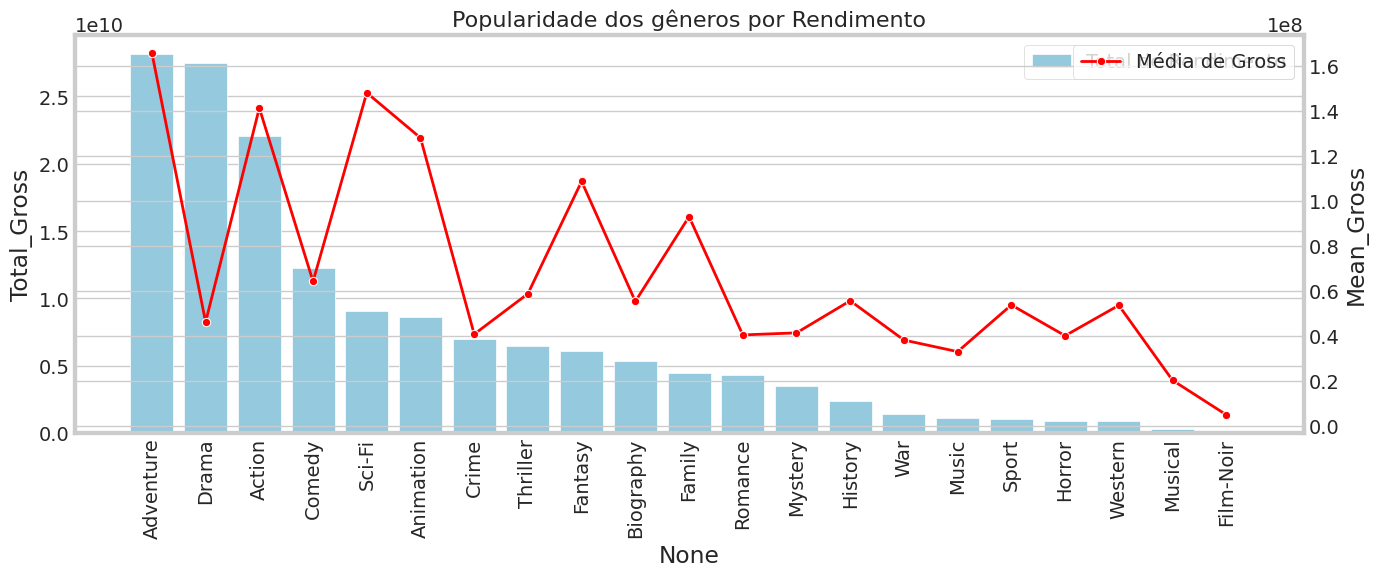

In [136]:
# Agrupamentos por gênero e gross (devido aos valores faltantes desta coluna, foi feito um novo df sem estas linhas)
df_gross = df_cleaned.copy()
df_gross = df_gross.dropna(subset=['Gross'])
movies_per_genre_gross = df_gross[genre_cols].sum()
gross_total = (df_gross[genre_cols].T @ df_gross["Gross"])
mean_gross_per_genre = gross_total / movies_per_genre_gross

# Organizando o DataFrame
genre_stats_gross = pd.DataFrame({
    "Total_Gross": gross_total,
    "Mean_Gross": mean_gross_per_genre,
    "Movies_Count": movies_per_genre_gross
}).sort_values("Total_Gross", ascending=False)

# Gráfico
plt.figure(figsize=(14,6))

# Gráfico de Barras com os totais
ax1 = sns.barplot(
    x=genre_stats_gross.index,
    y="Total_Gross",
    data=genre_stats_gross,
    color="skyblue",
    label="Total de Rendimento"
)

# Gráfico de Linha com a média
ax2 = plt.twinx()
sns.lineplot(
    x=genre_stats_gross.index,
    y="Mean_Gross",
    data=genre_stats_gross,
    marker="o",
    color="red",
    linewidth=2,
    label="Média de Gross",
    ax=ax2
)

# Títulos e legendas
plt.title("Popularidade dos gêneros por Rendimento", fontsize=16)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
plt.tight_layout()

plt.show()

- No gráfico anterior, há uma predominância do gênero 'Adventure', relevante em volume e em desempenho médio (indicando um bom mercado e filmes rentáveis). Os gêneros 'Sci-fy', 'Fantasy' e 'Family' se mostram lucrativos (média alta) mesmo com poucos filmes produzidos.

- Também foram investigadas as colunas com os diretores e estrelas do conjunto de dados. Foram calculadas as estatísticas gerais relativas ao rendimento dos filmes. Alguns nomes se destacam com valores médios de bilheteria mais altos, embora apareçam em poucas produções.
- Nomes associados a franquias de grande sucesso, como ["Vingadores"[14]](https://www.imdb.com/title/tt4154796/) aparecem com frequência.

In [137]:
director_stars = ['Director', 'Star1', 'Star2', 'Star3', 'Star4']
for col in director_stars:
    stats_director_stars = (df_gross.groupby(col)["Gross"].agg(["count", "mean", "median", "sum"]).sort_values("mean", ascending=False))
    print(f"Estatísticas para {col}")
    print(stats_director_stars.head(5))

Estatísticas para Director
                count          mean       median           sum
Director                                                      
Anthony Russo       4  5.512599e+08  543449915.5  2.205039e+09
Gareth Edwards      1  5.321773e+08  532177324.0  5.321773e+08
J.J. Abrams         3  4.743903e+08  257730019.0  1.423171e+09
Josh Cooley         1  4.340380e+08  434038008.0  4.340380e+08
Roger Allers        1  4.227838e+08  422783777.0  4.227838e+08
Estatísticas para Star1
                 count          mean       median           sum
Star1                                                          
Daisy Ridley         1  9.366622e+08  936662225.0  9.366622e+08
Sam Worthington      1  7.605076e+08  760507625.0  7.605076e+08
Joe Russo            4  5.512599e+08  543449915.5  2.205039e+09
Felicity Jones       1  5.321773e+08  532177324.0  5.321773e+08
Henry Thomas         1  4.351106e+08  435110554.0  4.351106e+08
Estatísticas para Star2
                   count          me

- A seguir, foi investigado rendimento total e médio para as categorias de classificação indicativa, com o objetivo de identificar possíveis relações entre o lucro e a indicação etária do filme.
- Como esta variável possui muitas categorias subrepresentadas, primeiro foi feito uma transformação para deixar apenas as 4 mais frequentes e as outras foram agrupadas como 'Other'.

In [138]:
# Agrupamento da coluna 'Certificate'
certificate_grouped = pd.value_counts(df_gross.Certificate)
mask = (certificate_grouped/certificate_grouped.sum() * 100).lt(10)
df_gross['Certificate_grouped'] = np.where(df_gross['Certificate'].isin(certificate_grouped[mask].index),'Other', df_gross['Certificate'])
df_gross['Certificate_grouped'].value_counts()

/tmp/ipython-input-3162908443.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  certificate_grouped = pd.value_counts(df_gross.Certificate)


,count
Certificate_grouped,
U,200
A,179
UA,164
Other,152
R,135


In [139]:
# Visualização da contagem, méida e mediana do rendimento por classificação indicativa
df_gross.groupby('Certificate_grouped')['Gross'].agg(['count', 'mean', 'median']).sort_values('mean', ascending=False)

,count,mean,median
Certificate_grouped,,,
UA,164,1.305049e+08,60770504.5
U,200,8.724658e+07,40155347.0
A,179,6.408571e+07,45598982.0
R,135,2.579360e+07,6391436.0
Other,152,1.778244e+07,3975446.5


- Diante destes resultados, foi observado que a indicação etária 'UA' tem o maior lucro médio e uma boa representação. Em seguida, 'A' e 'U' também possuem bons rendimentos e contagem de filmes. 'R' e 'Other' já não representam tantos rendimentos e são menos promissores para investir.

- Nesta seção, foram feitas análises com estatística inferencial. O objetivo foi investigar hipóteses sobre o mercado cinematográfico a partir dos dados.
- O primeiro passo foi investigar a correlação entre as variáveis numéricas.

In [140]:
# Calcular a matriz de correlação de Pearson
corr_cols = ['Gross', 'Meta_score', 'No_of_Votes', 'Runtime (min)', 'IMDB_Rating']
corr_pearson = df_cleaned[corr_cols].corr(method='pearson')
print(corr_pearson)

                  Gross  Meta_score  No_of_Votes  Runtime (min)  IMDB_Rating
Gross          1.000000   -0.030480     0.589527       0.140002     0.099393
Meta_score    -0.030480    1.000000    -0.020091      -0.031604     0.271374
No_of_Votes    0.589527   -0.020091     1.000000       0.172483     0.479308
Runtime (min)  0.140002   -0.031604     0.172483       1.000000     0.242751
IMDB_Rating    0.099393    0.271374     0.479308       0.242751     1.000000


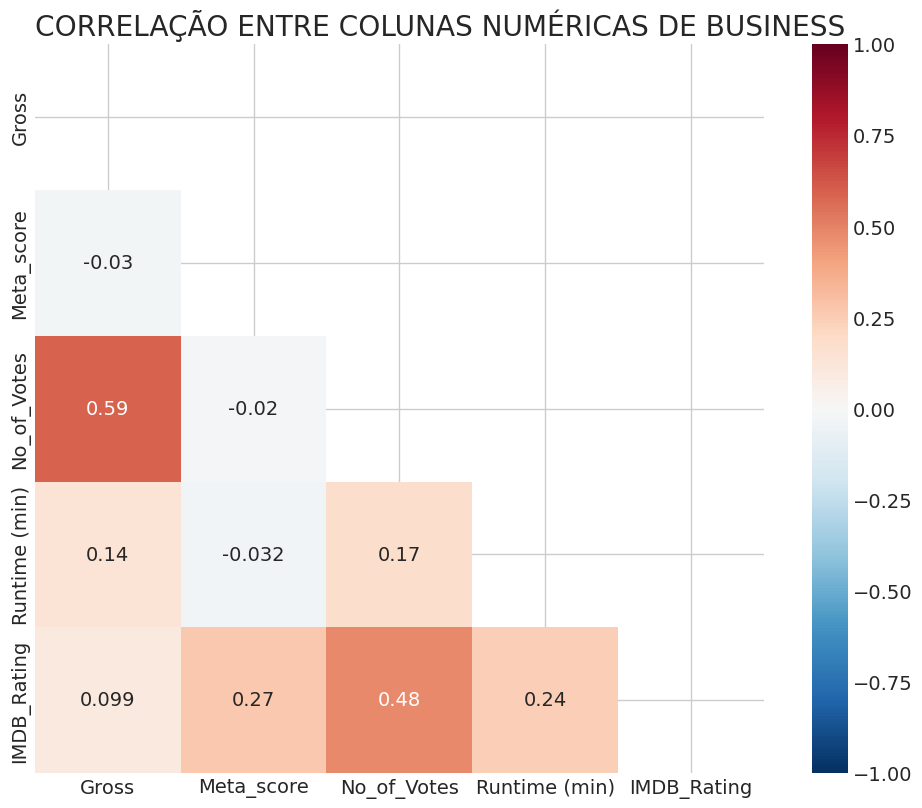

In [141]:
# função para criar máscara para exibir apenas a parte inferior da matriz de correlação
def mask_lower_triangle(correlation_matrix):
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Máscara para a parte superior
    return mask

# Criar a máscara para a parte inferior
mask = mask_lower_triangle(corr_pearson)

# Criar o gráfico de correlação com a máscara aplicada
fig, ax = plt.subplots(figsize=(11, 9))

# Gerar o heatmap com a máscara na parte superior da matriz
sns.heatmap(corr_pearson, mask=mask, annot=True, cmap='RdBu_r', square=True, vmin=-1, vmax=1)

# Título do gráfico
plt.title('Correlação entre colunas numéricas de Business'.upper(), loc='left')

plt.show()

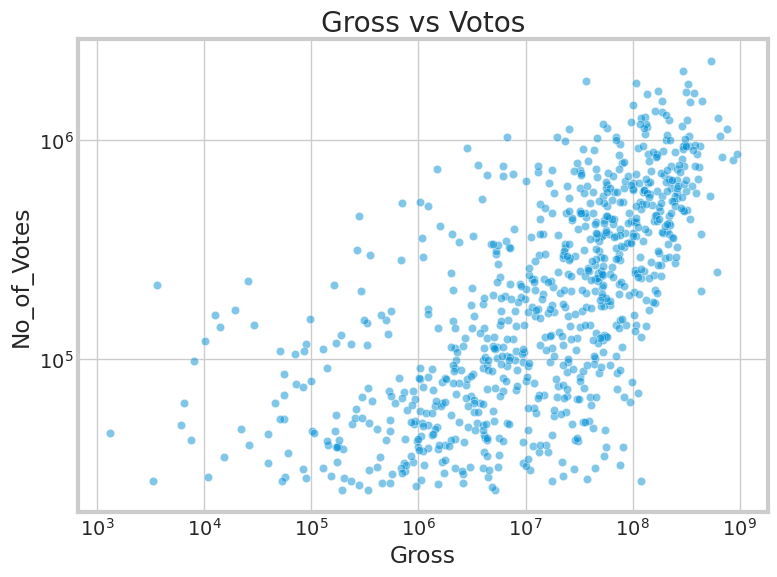

In [142]:
# Criar gráfico de dispersão para analisar Gross X No_of_Votes
fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(data=df_cleaned, x="Gross", y="No_of_Votes", alpha=0.5, ax=ax)
ax.set_xscale("log")
ax.set_yscale("log")

# Título
ax.set_title("Gross vs Votos")

plt.tight_layout()
plt.show()

- Nesta análise foi observado que a maior correlação entre as variáveis numéricas dos dados foi entre o rendimento e o números de votos dos filmes do IMDb (0,59). De acordo com o que já foi analisado, esse comportamento era esperado, já que um filme com alta bilheteria possui um alto engajamento na plataforma.
- As outras relações numéricas não demonstraram uma correlação evidente.

- Por fim, para analisar a hipótese de que o genero do filme influencia o seu rendimento médio, foi utilizado o teste t para amostras independentes, que verifica a diferença das médias entre os grupos.
- Como foi verificado que muitos gêneros são subrepresentados, primeiramente foi realizado o agrupamento para os 5 gêneros mais frequentes e os outros foram reunidos na categoria 'Other'
- A função do teste t foi retirada de uma biblioteca pessoal de testes de hipótese, elaborada para o projeto ["Yelp - Análise do estado do Tennessee" [13]](https://github.com/ana0212/Yelp---Analise-do-estado-do-Tennessee/blob/main/Notebook%20-%20Yelp%20-%20An%C3%A1lise%20do%20estado%20do%20Tennessee.ipynb)

In [143]:
# Teste de Levene para homogeneidade de variâncias
def teste_levene(df, var_quali, var_quanti, alfa=0.05):
    grupos = [df[df[var_quali] == categoria][var_quanti].dropna() for categoria in df[var_quali].unique()]
    resultado = stats.levene(*grupos)

    print("Teste de Levene:")
    print("Estatística:", resultado.statistic)
    print("Valor p:", resultado.pvalue)

    if resultado.pvalue <= alfa:
        print("Rejeita-se a hipótese nula. As variâncias não são homogêneas")
    else:
        print("Não se rejeita hipótese nula. As variâncias podem ser consideradas homogêneas")
    return resultado

# Função para realizar o Teste t para amostras independentes
def teste_t_amostras_ind(group_a, group_b, column, alfa):
    resultado_teste_levene = stats.levene(group_a[column], group_b[column])
    if resultado_teste_levene.pvalue <= alfa:
        equal_var=False
    else:
        equal_var=True
    resultado_t_test_ind = stats.ttest_ind(group_a[column], group_b[column], equal_var=equal_var)
    print("Teste t para Amostras Independentes:")
    print("Estatística t:", resultado_t_test_ind.statistic)
    print("Valor p:", resultado_t_test_ind.pvalue)
    if resultado_t_test_ind.pvalue <= alfa:
        print("Rejeita-se a hipótese nula, logo, há diferença significativa entre as médias nos grupos.")
    else:
        print("Não se rejeita a hipótese nula, logo, não há diferença significativa entre as médias nos grupos.")
    return

# Ordenar as colunas de gênero pela soma
genre_counts = df_gross[genres].sum().sort_values(ascending=False)

# Definir os gêneros principais (top 5)
top_genres = genre_counts.head(5).index.tolist()

# Criar a coluna "Other"
df_gross['Other'] = df_gross[genres].drop(columns=top_genres).max(axis=1)
genre_counts = df_gross[genres].sum().sort_values(ascending=False)

# Realizar o teste t nos gêneros principais
for genre in top_genres:
    print(f'Teste t para {genre}')
    teste_t_amostras_ind(df_gross[df_gross[genre] == 1], df_gross[df_gross[genre] == 0], 'Gross', 0.05)
    print("**********************")

# Realizar o teste t na coluna de gêneros agrupados - 'Other'
print(f'Teste t para Other')
teste_t_amostras_ind(df_gross[df_gross['Other'] == 1], df_gross[df_gross['Other'] == 0], 'Gross', 0.05)

Teste t para Drama
Teste t para Amostras Independentes:
Estatística t: -7.504231973840094
Valor p: 8.03681421388446e-13
Rejeita-se a hipótese nula, logo, há diferença significativa entre as médias nos grupos.
**********************
Teste t para Comedy
Teste t para Amostras Independentes:
Estatística t: -0.5674034235594563
Valor p: 0.5705939254320249
Não se rejeita a hipótese nula, logo, não há diferença significativa entre as médias nos grupos.
**********************
Teste t para Crime
Teste t para Amostras Independentes:
Estatística t: -5.158589564520013
Valor p: 3.582016310204171e-07
Rejeita-se a hipótese nula, logo, há diferença significativa entre as médias nos grupos.
**********************
Teste t para Adventure
Teste t para Amostras Independentes:
Estatística t: 9.089184935021335
Valor p: 1.6892301659400224e-16
Rejeita-se a hipótese nula, logo, há diferença significativa entre as médias nos grupos.
**********************
Teste t para Action
Teste t para Amostras Independentes:
E

In [144]:
print(stats)

<module 'scipy.stats' from '/usr/local/lib/python3.12/dist-packages/scipy/stats/__init__.py'>


- Diante destes resultados, foi concluído que:
  - Rejeita-se a hipótese nula (há diferença significativa entre médias) nas categorias 'Drama', 'Crime', 'Adventure' e 'Action', representando uma diferença no rendimento médio dos demais, também considerando a análise anterior do total de rendimentos.
  - 'Comedy' e 'Other' não apresentam diferença significativa no rendimento médio.


### Conclusões da Análise Exploratória
- Diante das análises apresentadas nesta seção e dos requisitos do cliente, algumas conclusões se mostram relevantes:
  - A duração mais comum no mercado é entre 90 e 140 minutos;
  - As distribuições de número de votos e rendimento são bastante desiguais, indicando que um investimento médio tem um retorno mais estável, enquanto poucos têm retornos muito altos;
  - Sobre os gêneros:
    - 'Scify' e 'Fantasy' geralmente possuem um alto engajamento;
    - 'Film-Noir' e 'Western' geralmente possuem boas avaliações;
    - 'Drama', 'Crime', 'Adventure' e 'Action' geralmente possuem bons rendimentos;
  - Nomes de atores e diretores associados a grandes franquias possuem filmes com alto rendimento;
  - Sobre as certificações: 'UA' se destaca mais no lucro, mas 'U' e 'A' também têm um bom desempenho.
- Estes resultados podem apoiar as decisões do estúdio para escolher qual tipo de filme deve ser o próximo a ser desenvolvido, de acordo com os objetivos da empresa.

## 3.2 Respondendo à questões específicas do negócio
- Nesta seção, a análise é focada em responder questões mais específicas sobre os dados, de acordo com os requisitos do cliente.

### a. Qual filme você recomendaria para uma pessoa que você não conhece?
- Para responder à esta questão, primeiramente foi feita uma pesquisa com fontes externas para compreender o cálculo do Metascore e como ele se relaciona com o valor do IMDb [[15]](https://www.metacritic.com/about-us/) .
- Em resumo, o Metascore é calculado a partir da seleção de um grupo diversificado de críticos altamente respeitados e da atribuição de notas às suas avaliações. Em seguida, é calculada a média ponderada destas notas.
- De acordo com [esta pesquisa [16]](https://www.databoosting.com/imdb-vs-metacritic-which-is-more-trustworthy#/), os valores do Metascore tendem a seguir uma distribuição mais parecida com a normal.
- Diante dessas informações e também de acordo com algumas características de Sistemas de Recomendações não personalizados, [presentes no material do Lisbon Data Science Academy [17]](https://github.com/LDSSA/batch6-students/blob/main/S05%20-%20Recommender%20Systems/BLU10%20-%20Non-personalised%20recommender%20systems/BLU10%20-%20Learning%20Notebook%20-%20Part%203%20of%203%20-%20Non-personalized.ipynb), decidiu-se utilizar o Metascore como critério principal, penalizando filmes com poucos votos para equilibrar a visão crítica e a popularidade.
- Então o Score da recomendação será o valor do Metascore vezes o número de votos da obra dividido pela média geral de votos do dataset.
- Em relação aos dados faltantes na coluna 'Meta_score', foi encontrado que obras pouco populares ou anteriores a 1999 não possuem os dados do Metascore, por isso foram eliminados, também sob a premissa de equilibrar crítica e popularidade [[16]](https://www.databoosting.com/imdb-vs-metacritic-which-is-more-trustworthy#/).

In [145]:
# Criar o dataframe das recomendações
df_recom = df.copy()
df_recom = df_recom.dropna(subset=['Meta_score'])

# Cálculo do score personalizado
mean_votes = df_recom['No_of_Votes'].mean()
df_recom['Score_Recom'] = df_recom['Meta_score'] * (df_recom['No_of_Votes'] / mean_votes)

# Apresentação dos filmes com melhor desempenho
df_recom.sort_values(by=['Score_Recom'], ascending=False).head()

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Runtime (min),Genre_list,Score_Recom
1,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444,152,"[Action, Crime, Drama]",622.542601
5,Pulp Fiction,1994,A,154 min,"Crime, Drama",8.9,"The lives of two mob hitmen, a boxer, a gangst...",94.0,Quentin Tarantino,John Travolta,Uma Thurman,Samuel L. Jackson,Bruce Willis,1826188,107928762,154,"[Crime, Drama]",552.364097
0,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411,175,"[Crime, Drama]",521.393358
4,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905,201,"[Action, Adventure, Drama]",496.882325
7,Inception,2010,UA,148 min,"Action, Adventure, Sci-Fi",8.8,A thief who steals corporate secrets through t...,74.0,Christopher Nolan,Leonardo DiCaprio,Joseph Gordon-Levitt,Elliot Page,Ken Watanabe,2067042,292576195,148,"[Action, Adventure, Sci-Fi]",492.190385


In [146]:
# Visualização do filme que responde à pergunta
answer = df_recom.sort_values(by=['Score_Recom'], ascending=False).head(1)
print(answer.to_string(index=False))

   Series_Title Released_Year Certificate Runtime                Genre  IMDB_Rating                                                                                                                                                                                      Overview  Meta_score          Director          Star1        Star2         Star3         Star4  No_of_Votes     Gross Runtime (min)             Genre_list  Score_Recom
The Dark Knight          2008          UA 152 min Action, Crime, Drama          9.0 When the menace known as the Joker wreaks havoc and chaos on the people of Gotham, Batman must accept one of the greatest psychological and physical tests of his ability to fight injustice.        84.0 Christopher Nolan Christian Bale Heath Ledger Aaron Eckhart Michael Caine      2303232 534858444           152 [Action, Crime, Drama]   622.542601


- Respondendo à questão, o filme indicado seria 'The Dark Knight' ('Batman: O Cavaleiro das Trevas', no Brasil), de 2008, dirigido por Christopher Nolan e estrelado por Christian Bale e Heath Ledger. Ele tem Score do IMDb de 9.0, Metascore de 84.0 e 2.303.232 de votos. Seu faturamento foi de 534.858.444 de dólares. Para maiores informações sobre este filme, acessar sua [página do IMDb [18]](https://www.imdb.com/title/tt0468569/)

### b. Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?
- De acordo com a análise anterior, os fatores mais relevantes para a expectativa de faturamento de um filme são o gênero (Aventura, Ação, Drama e Crime) e classificação indicativa ('UA' - acesso irrestrito, sob orientação parental; seguido de 'U' - acesso irrestrito; e 'A', acesso somente para adultos). Adicionalmente, também foi observado que possuir diretores ou estrelas associados a grandes franquias também influencia o faturamento.

### c. Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?
- Para responder à está questão, primeiramente foram analisadas as 20 palavras mais frequentes em toda coluna 'Overview' e as 10 palavras mais relevantes de acordo com o TF-IDF e qui-quadrado de cada gênero.
- Os dados da coluna 'Overview' já tinham sido tratados na limpeza de dados, utilizando técnicas como tokenização e stemmer. Então, para obter as contagens de palavras, foi utilizado o CountVectorizer(), com a técnica de Bag of Words ("saco de palavras"), que é um tipo de vetorização baseado na contagem de palavras, em que cada documento é representado por um vetor com o tamanho do nosso vocabulário, e cada atributo representa o número de vezes que cada palavra do vocabulário aparece no documento [[18]](https://github.com/LDSSA/batch7-students/blob/main/S04%20-%20Text%20Classification/BLU07%20-%20Feature%20Extraction/Learning%20notebook%20-%20Part%202%20of%203%20-%20N-gram%20vectorizers.ipynb) [[19]](https://github.com/LDSSA/batch7-students/blob/main/S04%20-%20Text%20Classification/BLU07%20-%20Feature%20Extraction/Learning%20notebook%20-%20Part%203%20of%203%20-%20Sentiment%20analysis.ipynb)

- O código a seguir foi adaptado do projeto ["Yelp - Análise do estado do Tennessee" [13]](https://github.com/ana0212/Yelp---Analise-do-estado-do-Tennessee/blob/main/Notebook%20-%20Yelp%20-%20An%C3%A1lise%20do%20estado%20do%20Tennessee.ipynb)

/tmp/ipython-input-323993386.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Word', x='Count', data=df_common_words, palette=sns.light_palette("#d32323", n_colors=40, reverse=True))
/tmp/ipython-input-323993386.py:21: UserWarning: The palette list has more values (40) than needed (20), which may not be intended.
  sns.barplot(y='Word', x='Count', data=df_common_words, palette=sns.light_palette("#d32323", n_colors=40, reverse=True))


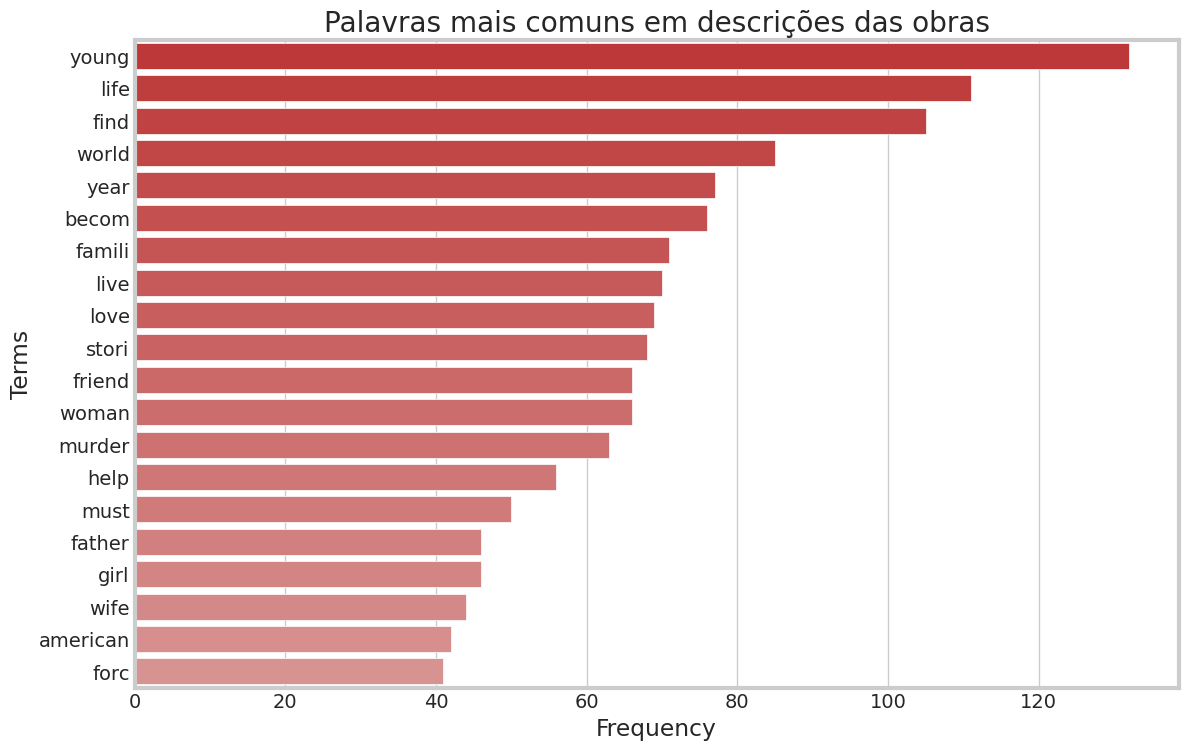

In [147]:
# Contar as palavras mais comuns
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_cleaned['Overview'].dropna())

# Somar as ocorrências de cada palavra
word_counts = np.asarray(X.sum(axis=0)).flatten()
word_freq = Counter(dict(zip(vectorizer.get_feature_names_out(), word_counts)))

# Filtrar apenas palavras com mais de 3 letras
filtered_word_freq = {word: count for word, count in word_freq.items() if len(word) > 3}

# Selecionar as 20 palavras mais comuns
common_words = Counter(filtered_word_freq).most_common(20)
words, counts = zip(*common_words)

# Criar DataFrame para facilitar a plotagem com Seaborn
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])

# Gráfico de barras dos termos mais comuns com gradiente de cor
plt.figure(figsize=(12, 8))
sns.barplot(y='Word', x='Count', data=df_common_words, palette=sns.light_palette("#d32323", n_colors=40, reverse=True))
plt.title('Palavras mais comuns em descrições das obras')
plt.xlabel('Frequency')
plt.ylabel('Terms')
plt.show()

- Para comparar as palavras gerais com as mais relevantes de cada gênero, foi utilizada a técnica do TF-IDF, que, em resumo, mede a frequência do termo, ponderada por sua raridade em todo o conjunto de dados, ajudando a encontrar as palavras mais relevantes de cada gênero [[18]](https://github.com/LDSSA/batch7-students/blob/main/S04%20-%20Text%20Classification/BLU07%20-%20Feature%20Extraction/Learning%20notebook%20-%20Part%202%20of%203%20-%20N-gram%20vectorizers.ipynb).
- Em seguida, foi aplicado o teste qui-quadrado, que examina a associação entre variáveis categóricas [[20]](https://github.com/LDSSA/batch7-students/blob/main/S04%20-%20Text%20Classification/BLU08%20-%20Dimensionality%20Reduction/Learning%20notebook%20-%20Part%201%20of%203%20-%20Dimensionality%20reduction%20and%20feature%20selection.ipynb).
- O código a seguir foi adaptado do [tutorial de NLP do Lisbon Data Science Academy[20]](https://github.com/LDSSA/batch7-students/blob/main/S04%20-%20Text%20Classification/BLU08%20-%20Dimensionality%20Reduction/Learning%20notebook%20-%20Part%201%20of%203%20-%20Dimensionality%20reduction%20and%20feature%20selection.ipynb) e do projeto ["Yelp - Análise do estado do Tennessee" [13]](https://github.com/ana0212/Yelp---Analise-do-estado-do-Tennessee/blob/main/Notebook%20-%20Yelp%20-%20An%C3%A1lise%20do%20estado%20do%20Tennessee.ipynb). Para este contexto, o qui-quadrado não foi utilizado como técnica de feature selection, mas sim, para interpretar a associação entre palavra e gênero.

/tmp/ipython-input-1965242625.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Word', x='Chi2', data=df_chi2,
/tmp/ipython-input-1965242625.py:24: UserWarning: The palette list has more values (40) than needed (10), which may not be intended.
  sns.barplot(y='Word', x='Chi2', data=df_chi2,


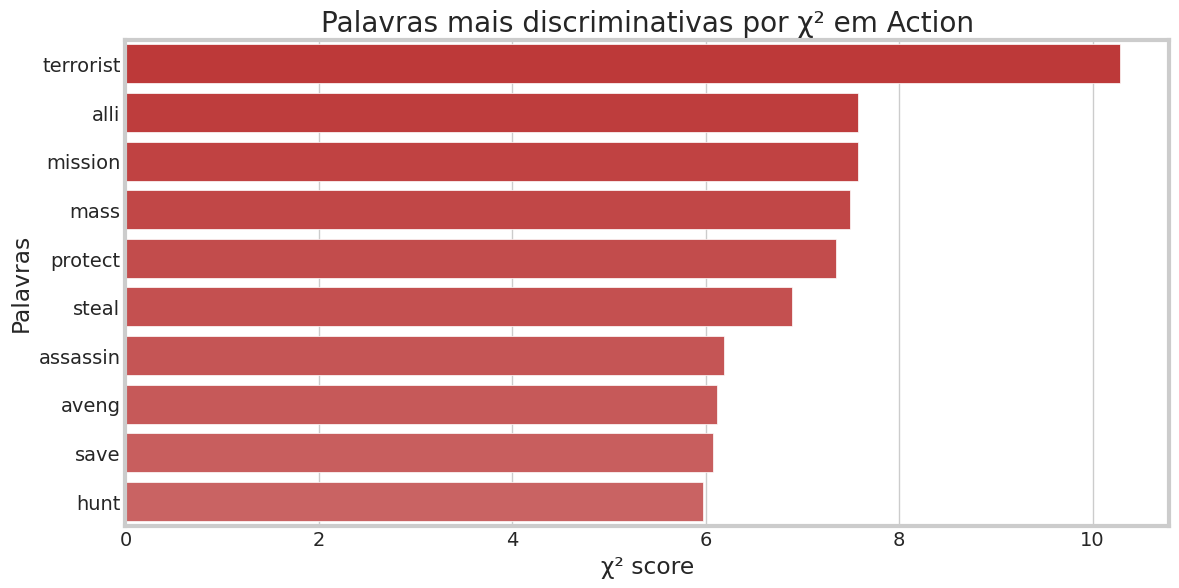

/tmp/ipython-input-1965242625.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Word', x='Chi2', data=df_chi2,
/tmp/ipython-input-1965242625.py:24: UserWarning: The palette list has more values (40) than needed (10), which may not be intended.
  sns.barplot(y='Word', x='Chi2', data=df_chi2,


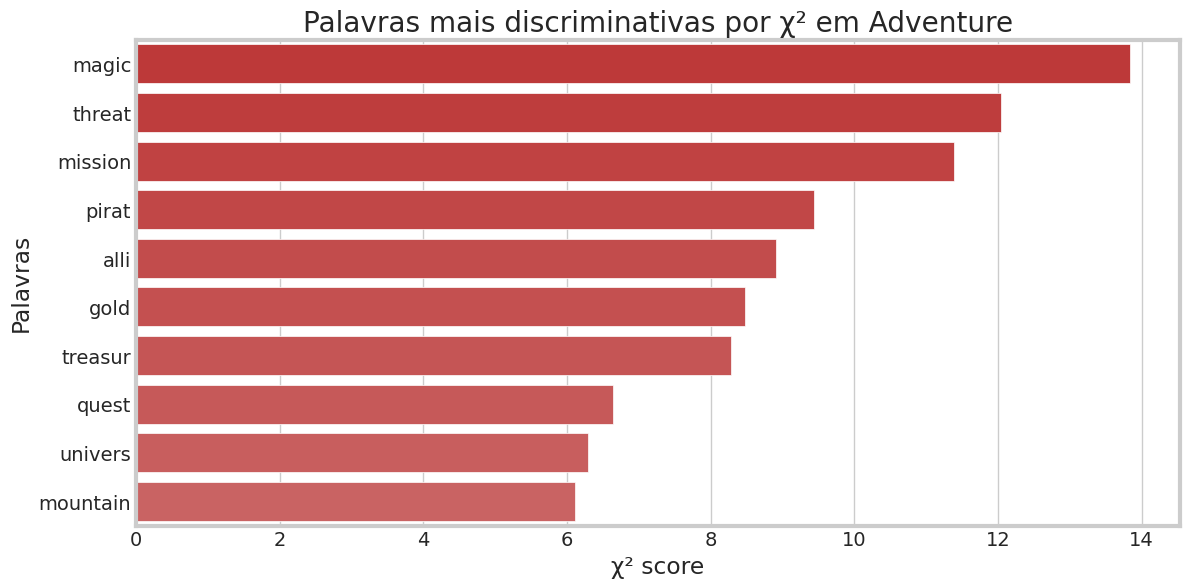

/tmp/ipython-input-1965242625.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Word', x='Chi2', data=df_chi2,
/tmp/ipython-input-1965242625.py:24: UserWarning: The palette list has more values (40) than needed (10), which may not be intended.
  sns.barplot(y='Word', x='Chi2', data=df_chi2,


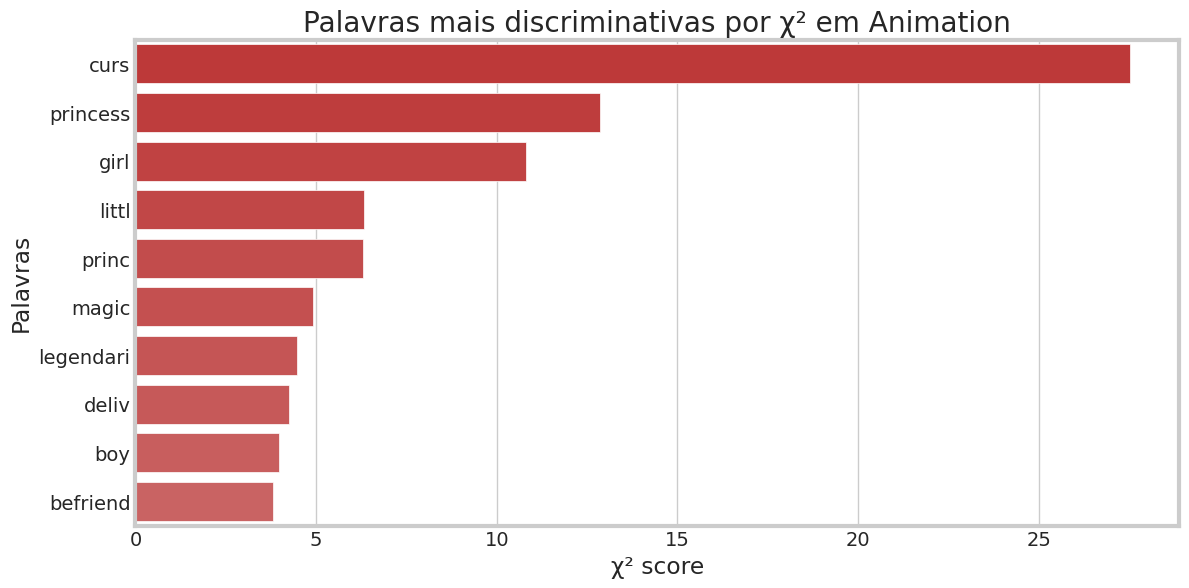

/tmp/ipython-input-1965242625.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Word', x='Chi2', data=df_chi2,
/tmp/ipython-input-1965242625.py:24: UserWarning: The palette list has more values (40) than needed (10), which may not be intended.
  sns.barplot(y='Word', x='Chi2', data=df_chi2,


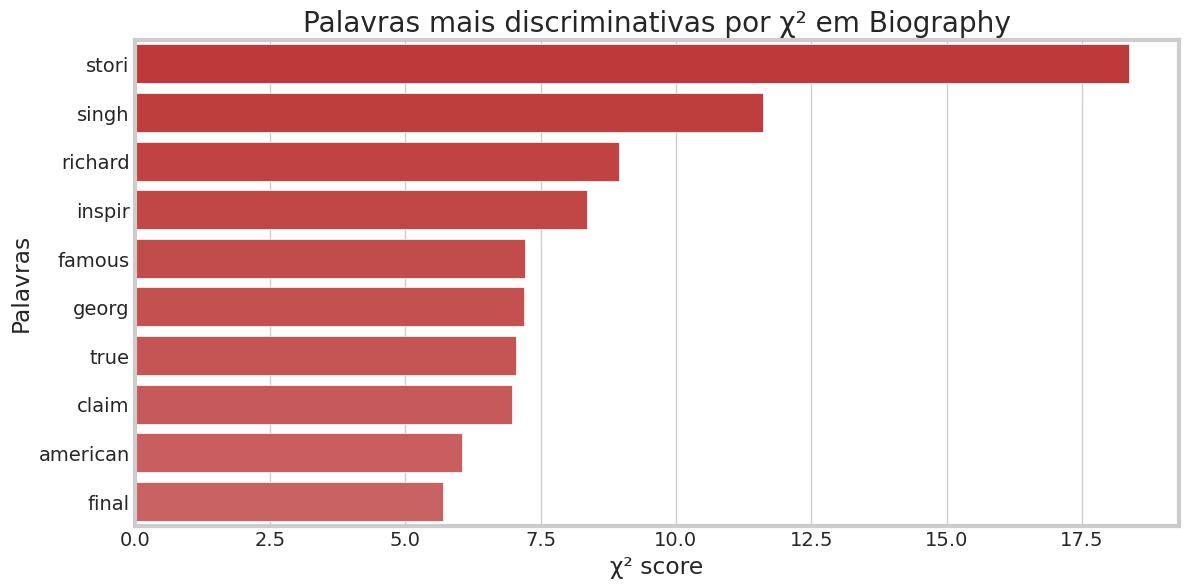

/tmp/ipython-input-1965242625.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Word', x='Chi2', data=df_chi2,
/tmp/ipython-input-1965242625.py:24: UserWarning: The palette list has more values (40) than needed (10), which may not be intended.
  sns.barplot(y='Word', x='Chi2', data=df_chi2,


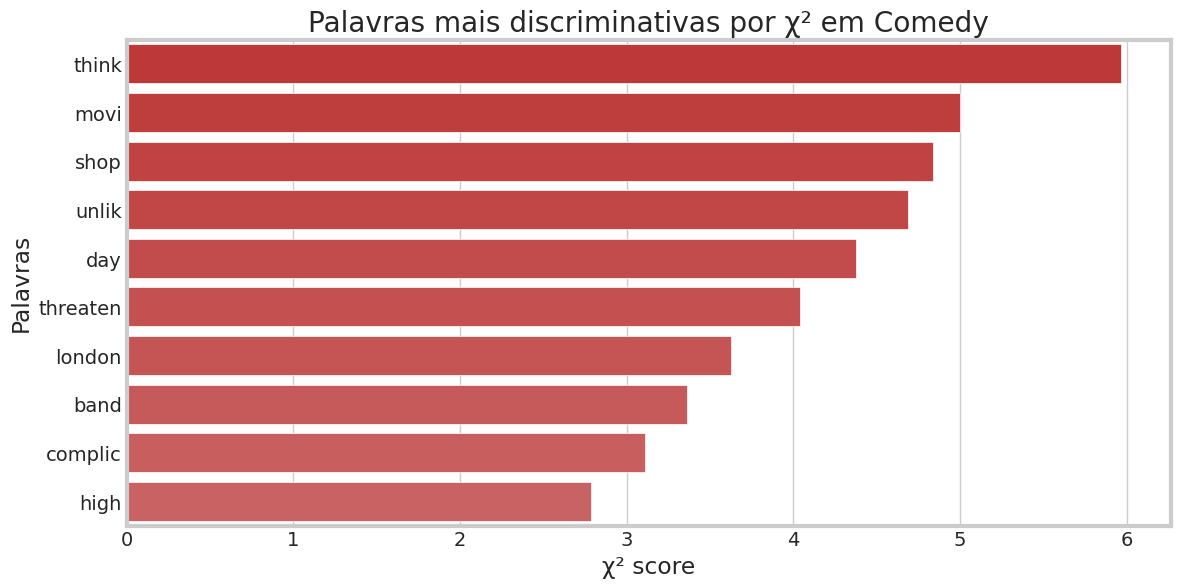

/tmp/ipython-input-1965242625.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Word', x='Chi2', data=df_chi2,
/tmp/ipython-input-1965242625.py:24: UserWarning: The palette list has more values (40) than needed (10), which may not be intended.
  sns.barplot(y='Word', x='Chi2', data=df_chi2,


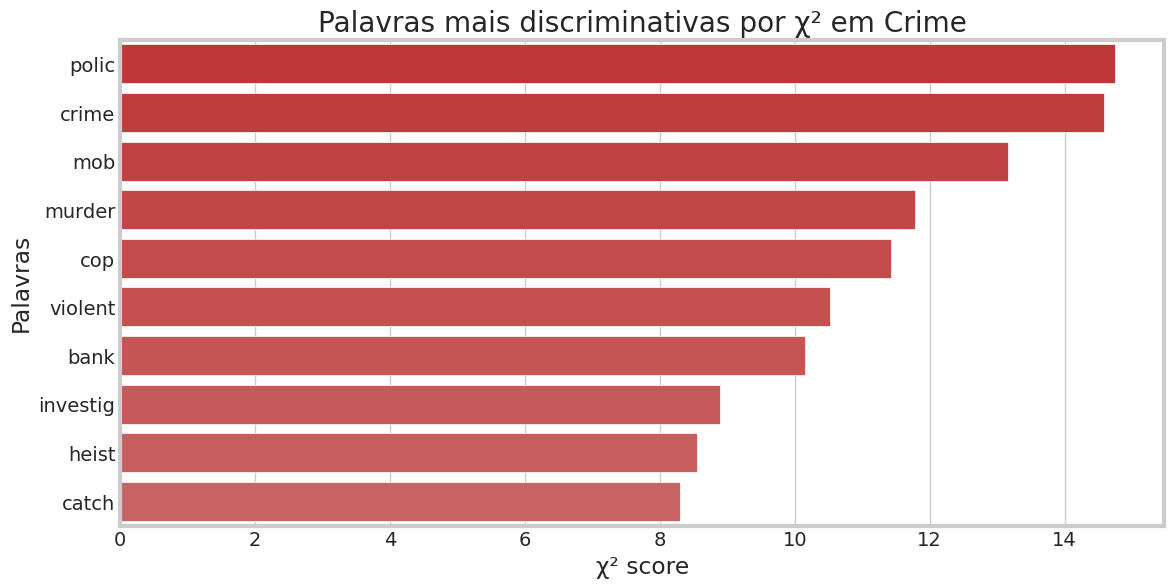

/tmp/ipython-input-1965242625.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Word', x='Chi2', data=df_chi2,
/tmp/ipython-input-1965242625.py:24: UserWarning: The palette list has more values (40) than needed (10), which may not be intended.
  sns.barplot(y='Word', x='Chi2', data=df_chi2,


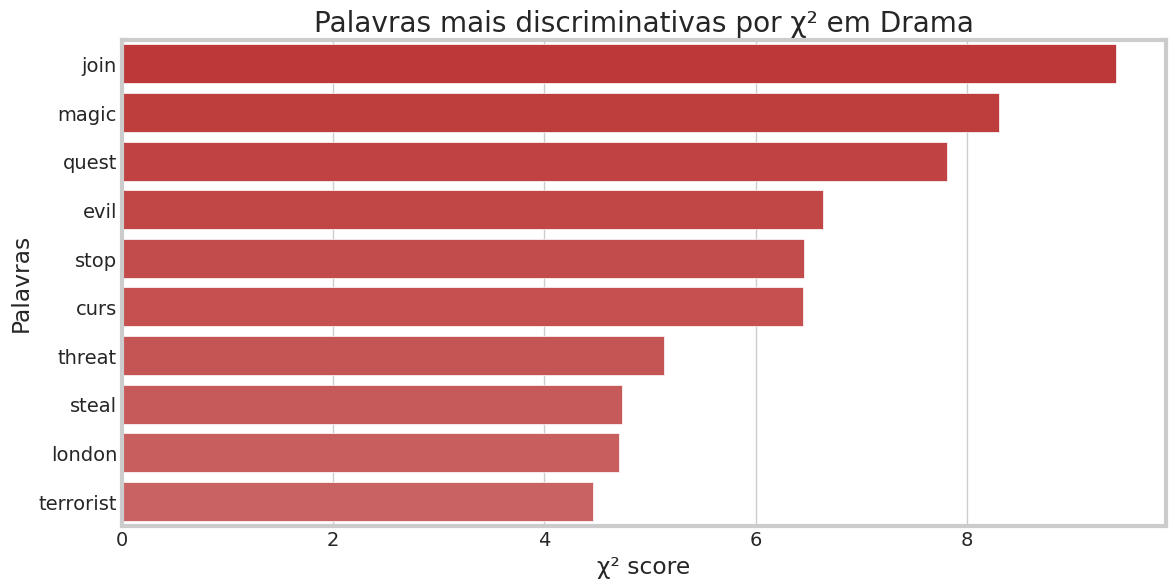

/tmp/ipython-input-1965242625.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Word', x='Chi2', data=df_chi2,
/tmp/ipython-input-1965242625.py:24: UserWarning: The palette list has more values (40) than needed (10), which may not be intended.
  sns.barplot(y='Word', x='Chi2', data=df_chi2,


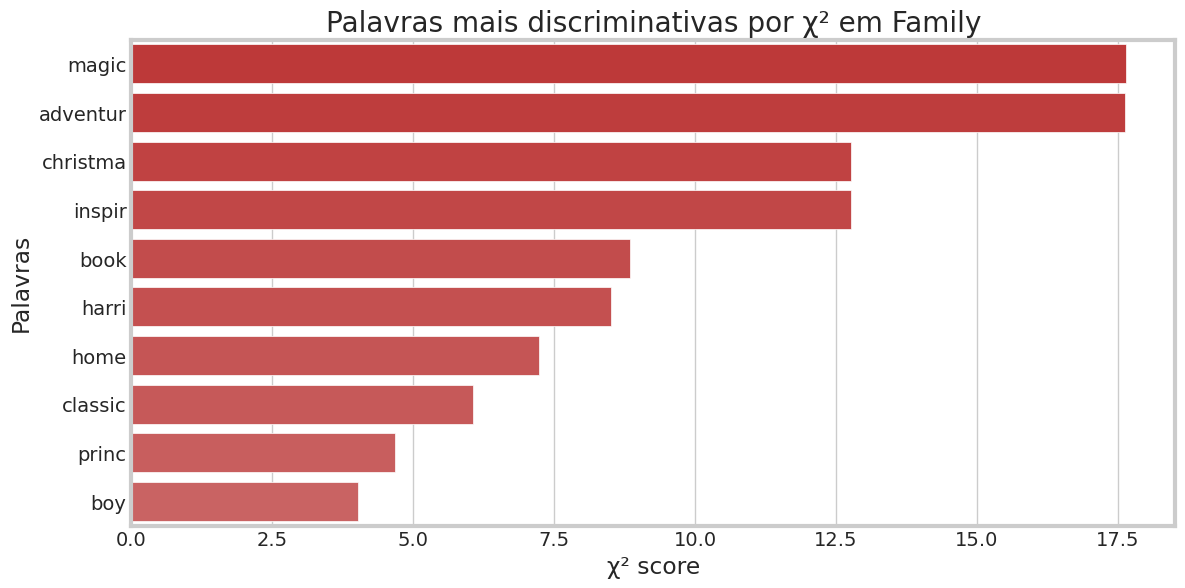

/tmp/ipython-input-1965242625.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Word', x='Chi2', data=df_chi2,
/tmp/ipython-input-1965242625.py:24: UserWarning: The palette list has more values (40) than needed (10), which may not be intended.
  sns.barplot(y='Word', x='Chi2', data=df_chi2,


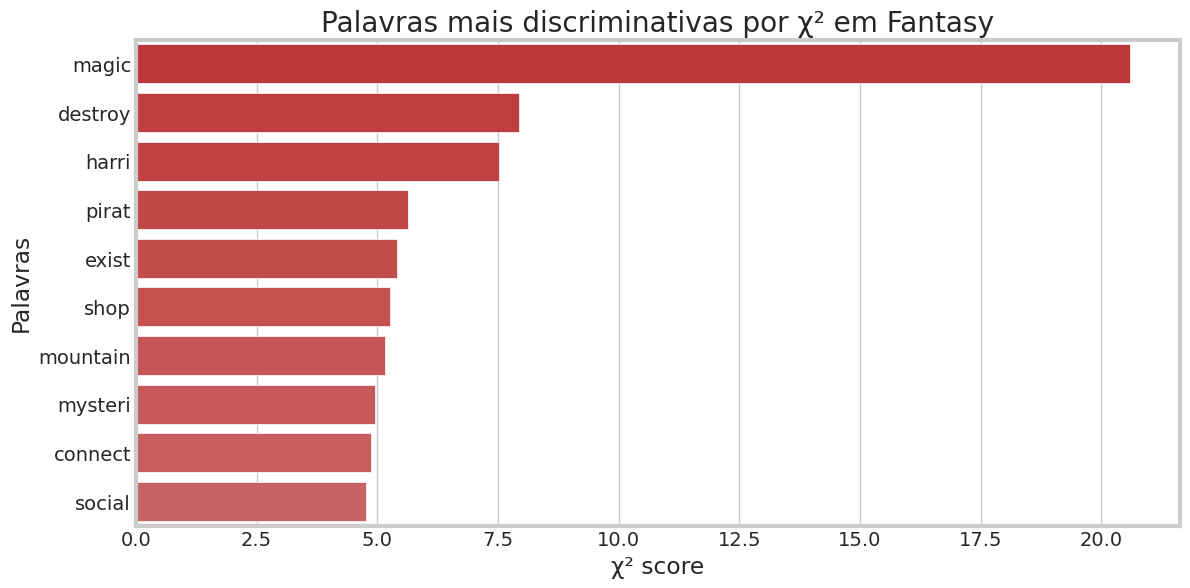

/tmp/ipython-input-1965242625.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Word', x='Chi2', data=df_chi2,
/tmp/ipython-input-1965242625.py:24: UserWarning: The palette list has more values (40) than needed (10), which may not be intended.
  sns.barplot(y='Word', x='Chi2', data=df_chi2,


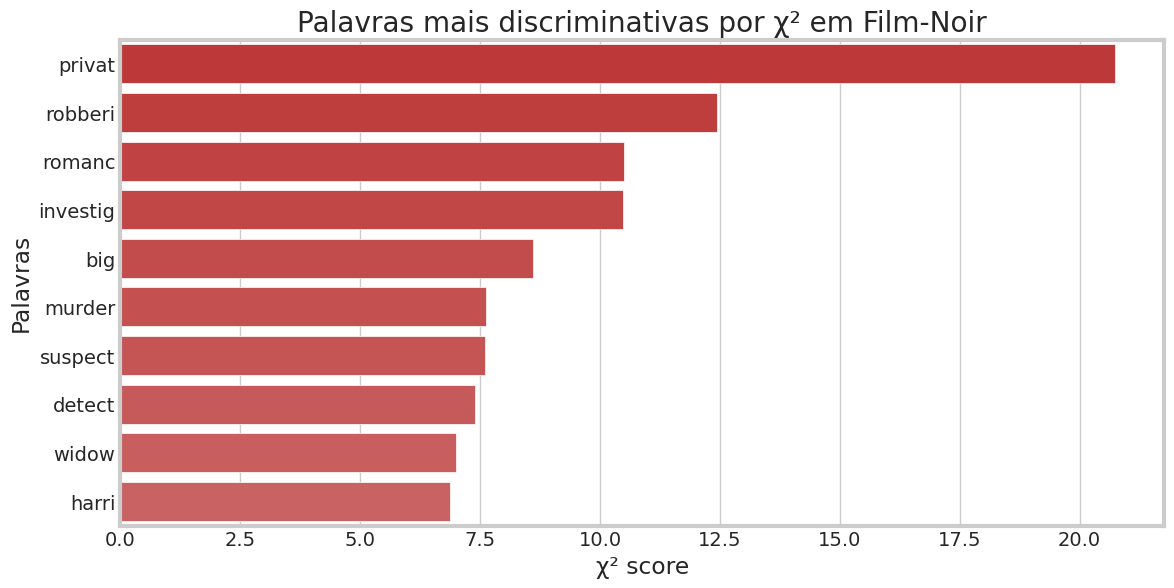

/tmp/ipython-input-1965242625.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Word', x='Chi2', data=df_chi2,
/tmp/ipython-input-1965242625.py:24: UserWarning: The palette list has more values (40) than needed (10), which may not be intended.
  sns.barplot(y='Word', x='Chi2', data=df_chi2,


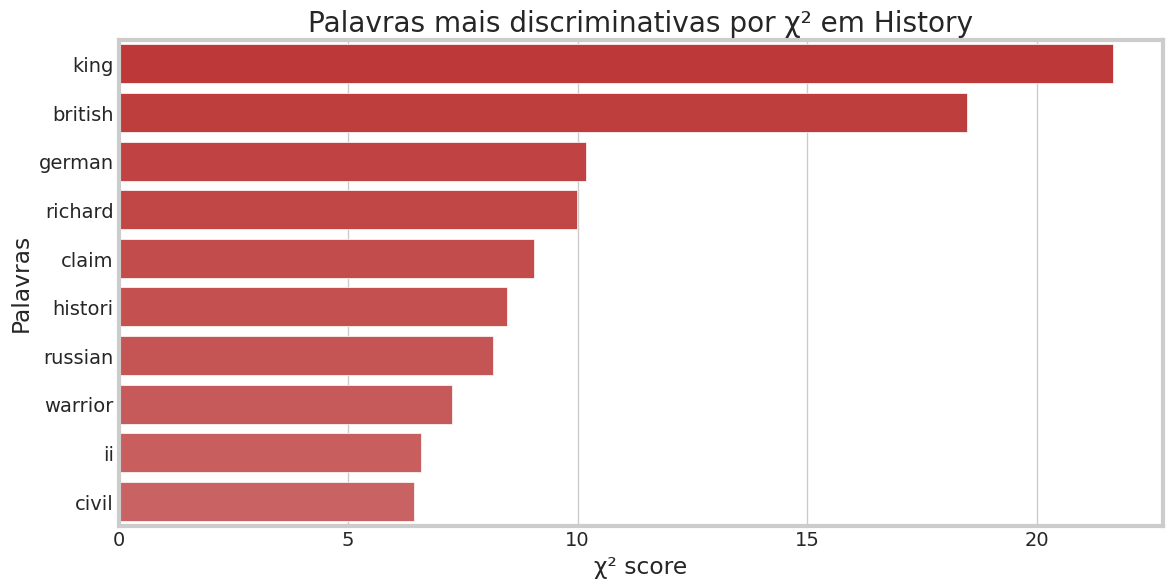

/tmp/ipython-input-1965242625.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Word', x='Chi2', data=df_chi2,
/tmp/ipython-input-1965242625.py:24: UserWarning: The palette list has more values (40) than needed (10), which may not be intended.
  sns.barplot(y='Word', x='Chi2', data=df_chi2,


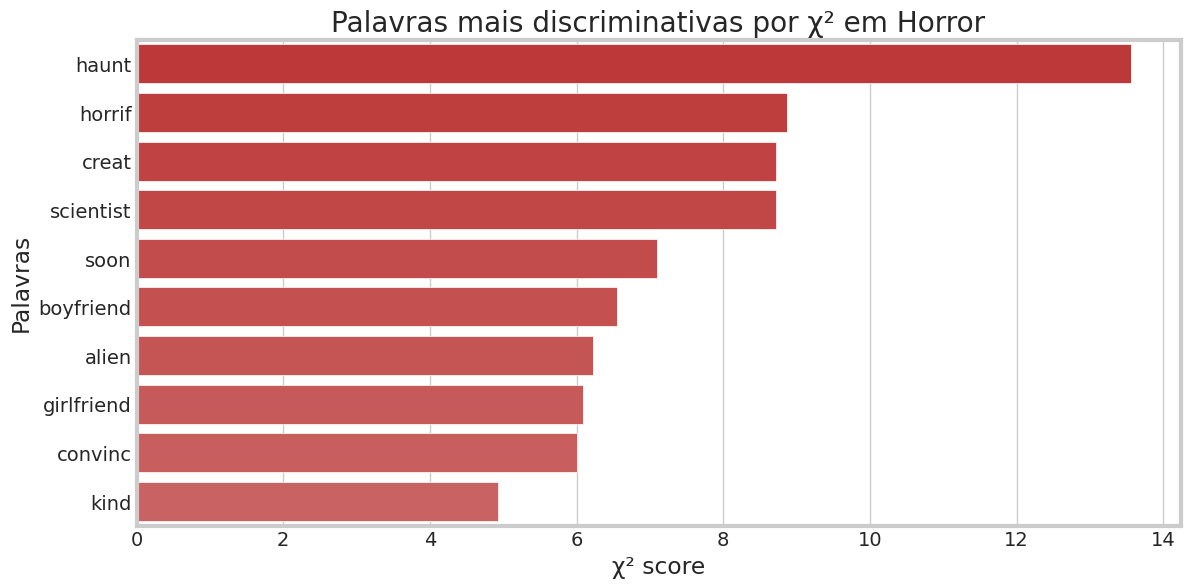

/tmp/ipython-input-1965242625.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Word', x='Chi2', data=df_chi2,
/tmp/ipython-input-1965242625.py:24: UserWarning: The palette list has more values (40) than needed (10), which may not be intended.
  sns.barplot(y='Word', x='Chi2', data=df_chi2,


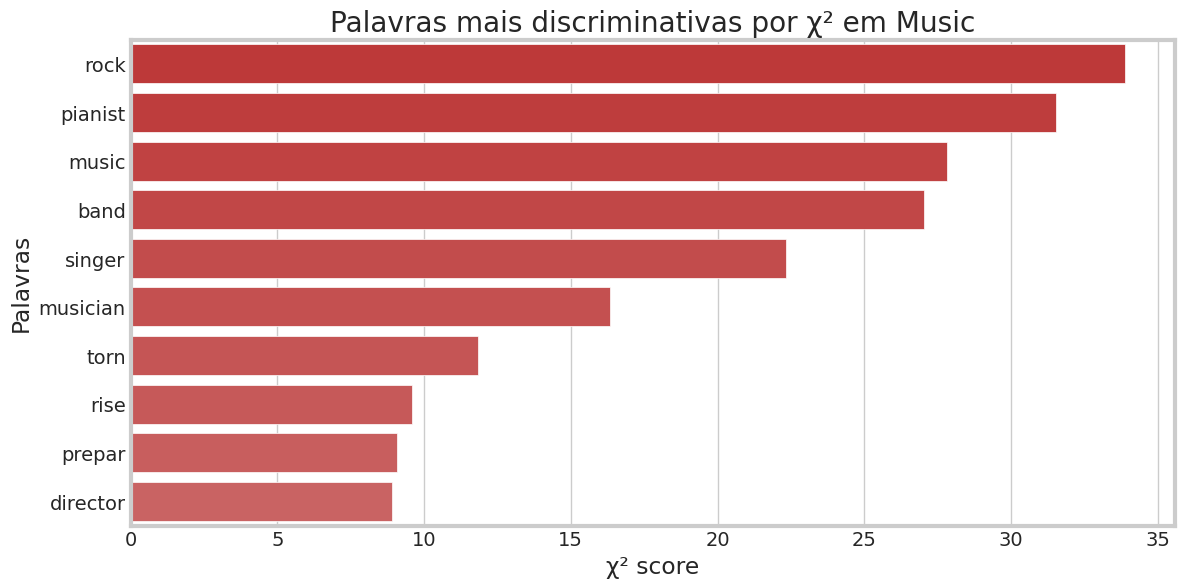

/tmp/ipython-input-1965242625.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Word', x='Chi2', data=df_chi2,
/tmp/ipython-input-1965242625.py:24: UserWarning: The palette list has more values (40) than needed (10), which may not be intended.
  sns.barplot(y='Word', x='Chi2', data=df_chi2,


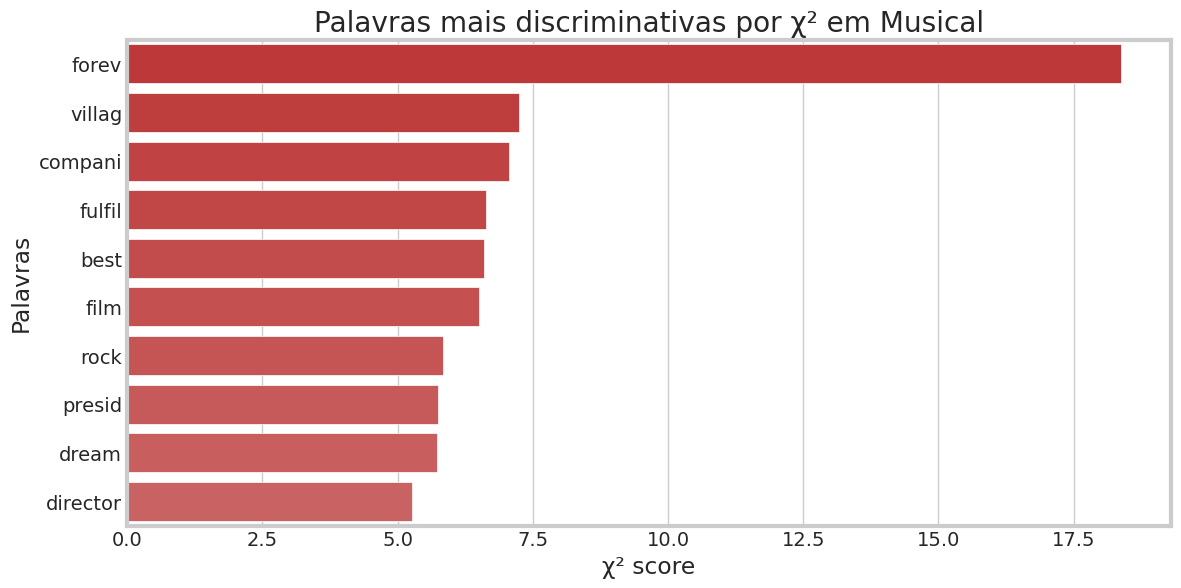

/tmp/ipython-input-1965242625.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Word', x='Chi2', data=df_chi2,
/tmp/ipython-input-1965242625.py:24: UserWarning: The palette list has more values (40) than needed (10), which may not be intended.
  sns.barplot(y='Word', x='Chi2', data=df_chi2,


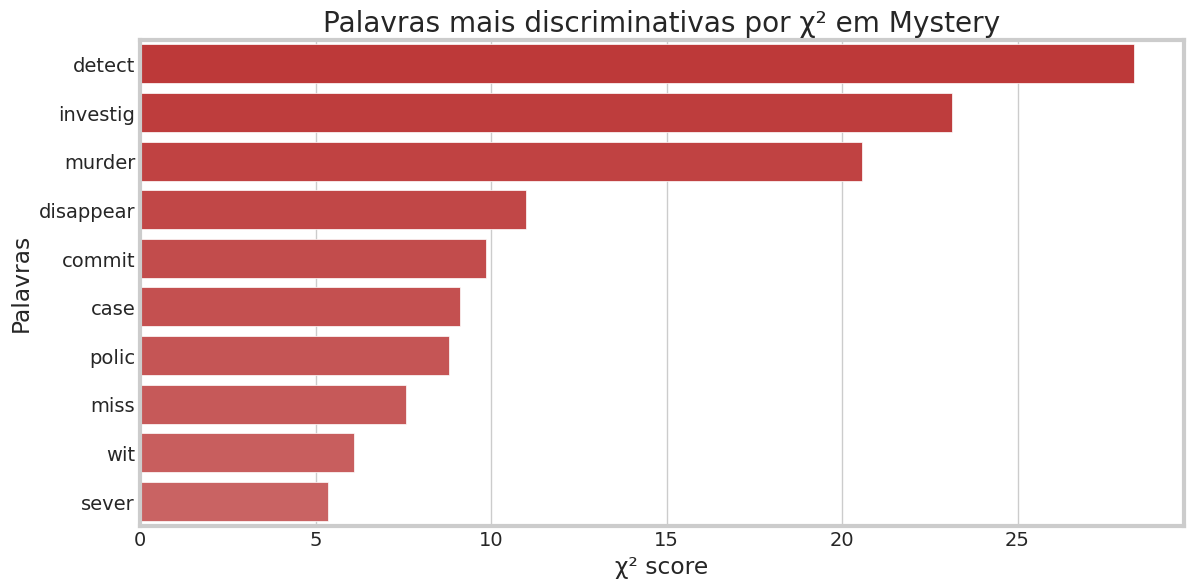

/tmp/ipython-input-1965242625.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Word', x='Chi2', data=df_chi2,
/tmp/ipython-input-1965242625.py:24: UserWarning: The palette list has more values (40) than needed (10), which may not be intended.
  sns.barplot(y='Word', x='Chi2', data=df_chi2,


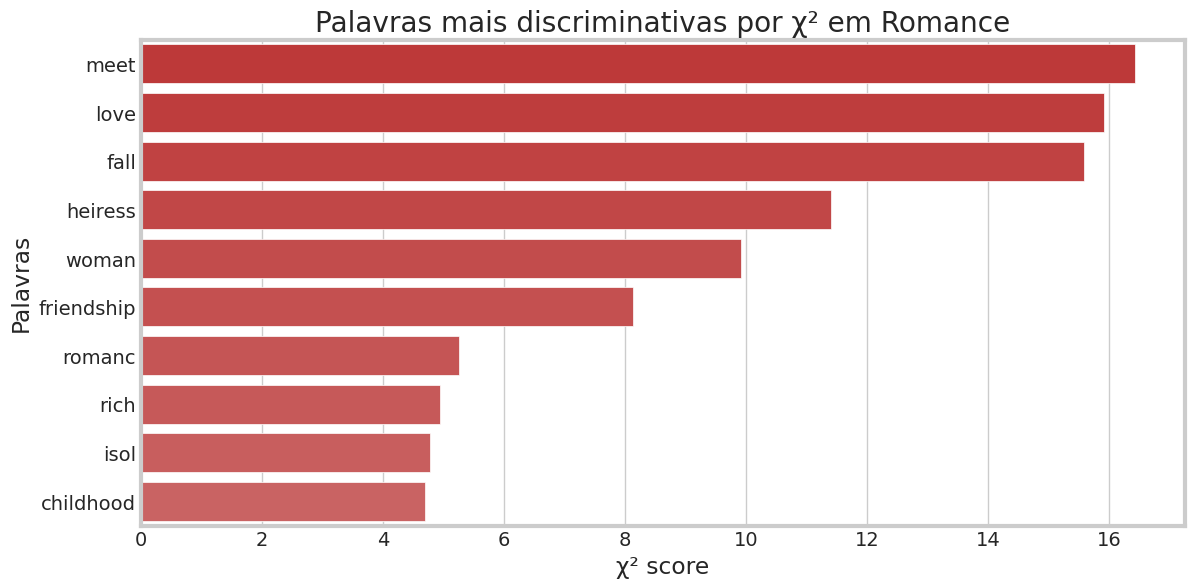

/tmp/ipython-input-1965242625.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Word', x='Chi2', data=df_chi2,
/tmp/ipython-input-1965242625.py:24: UserWarning: The palette list has more values (40) than needed (10), which may not be intended.
  sns.barplot(y='Word', x='Chi2', data=df_chi2,


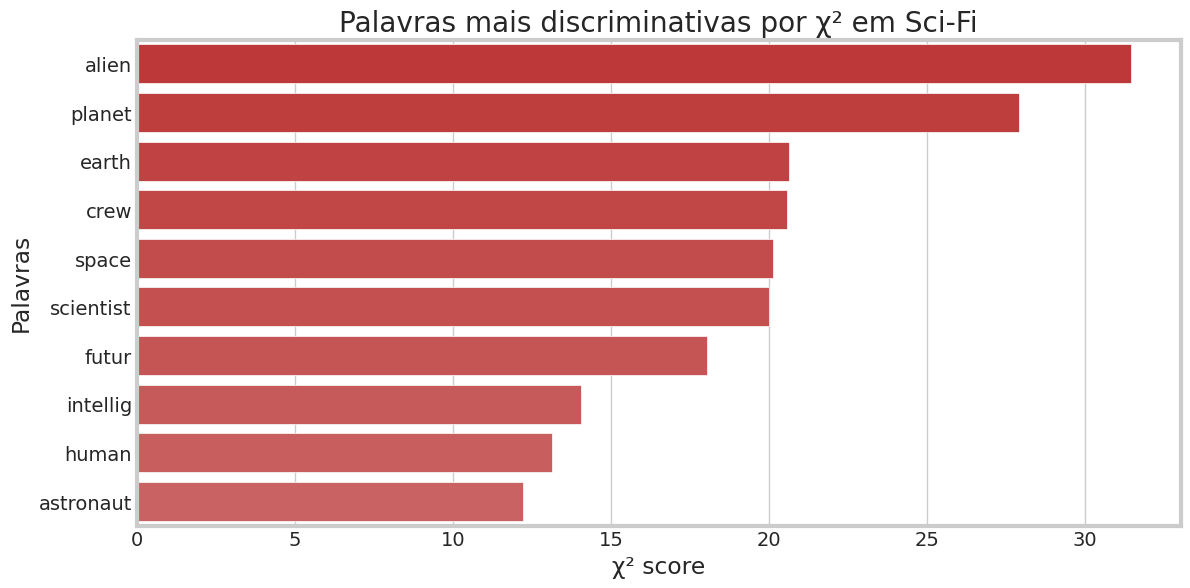

/tmp/ipython-input-1965242625.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Word', x='Chi2', data=df_chi2,
/tmp/ipython-input-1965242625.py:24: UserWarning: The palette list has more values (40) than needed (10), which may not be intended.
  sns.barplot(y='Word', x='Chi2', data=df_chi2,


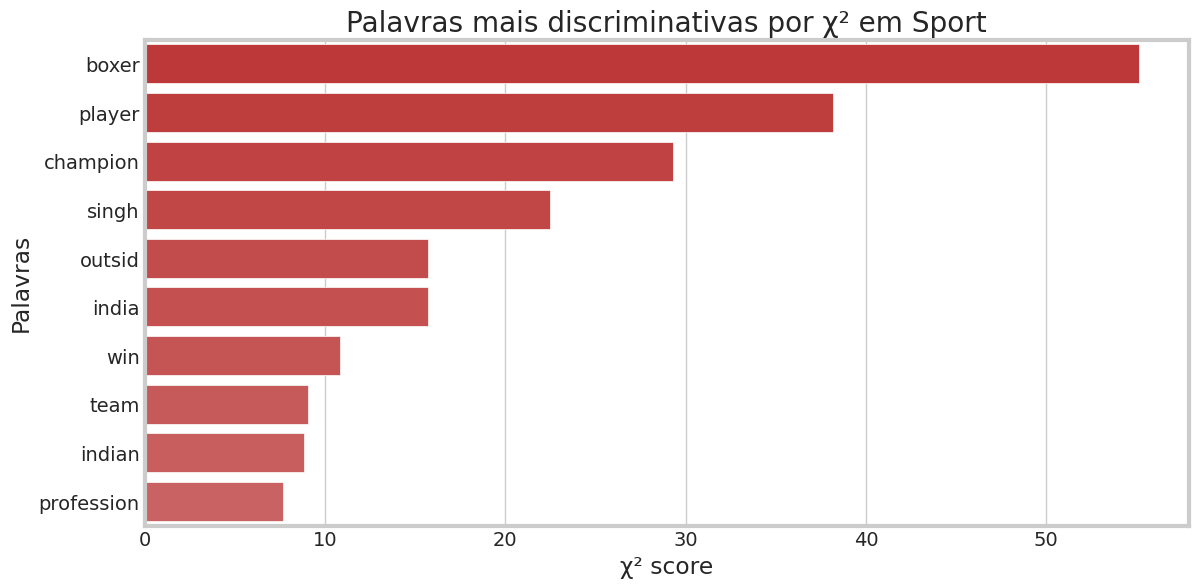

/tmp/ipython-input-1965242625.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Word', x='Chi2', data=df_chi2,
/tmp/ipython-input-1965242625.py:24: UserWarning: The palette list has more values (40) than needed (10), which may not be intended.
  sns.barplot(y='Word', x='Chi2', data=df_chi2,


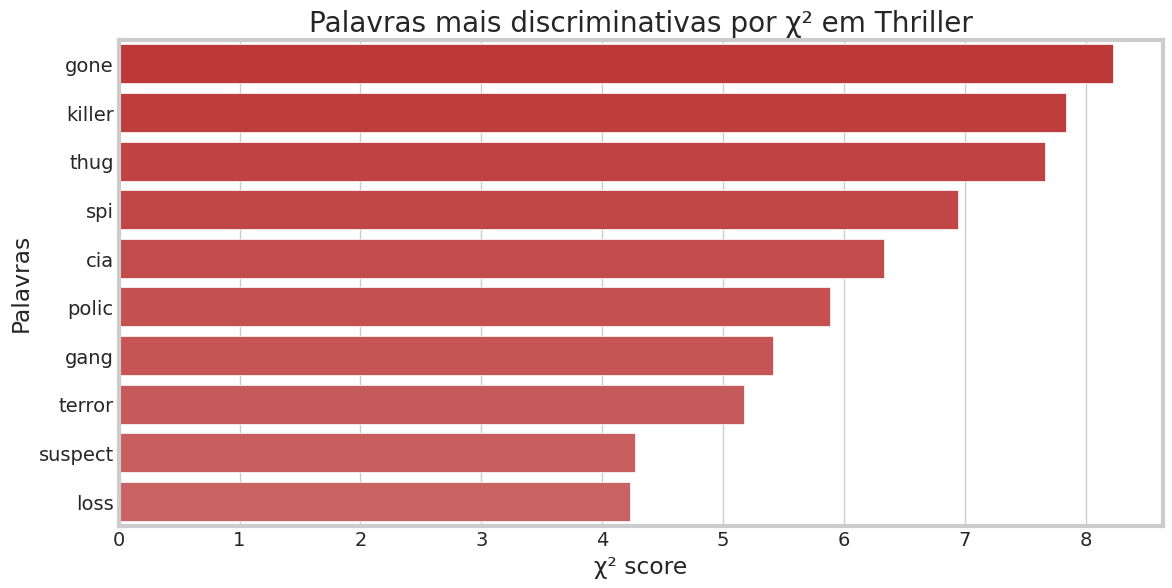

/tmp/ipython-input-1965242625.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Word', x='Chi2', data=df_chi2,
/tmp/ipython-input-1965242625.py:24: UserWarning: The palette list has more values (40) than needed (10), which may not be intended.
  sns.barplot(y='Word', x='Chi2', data=df_chi2,


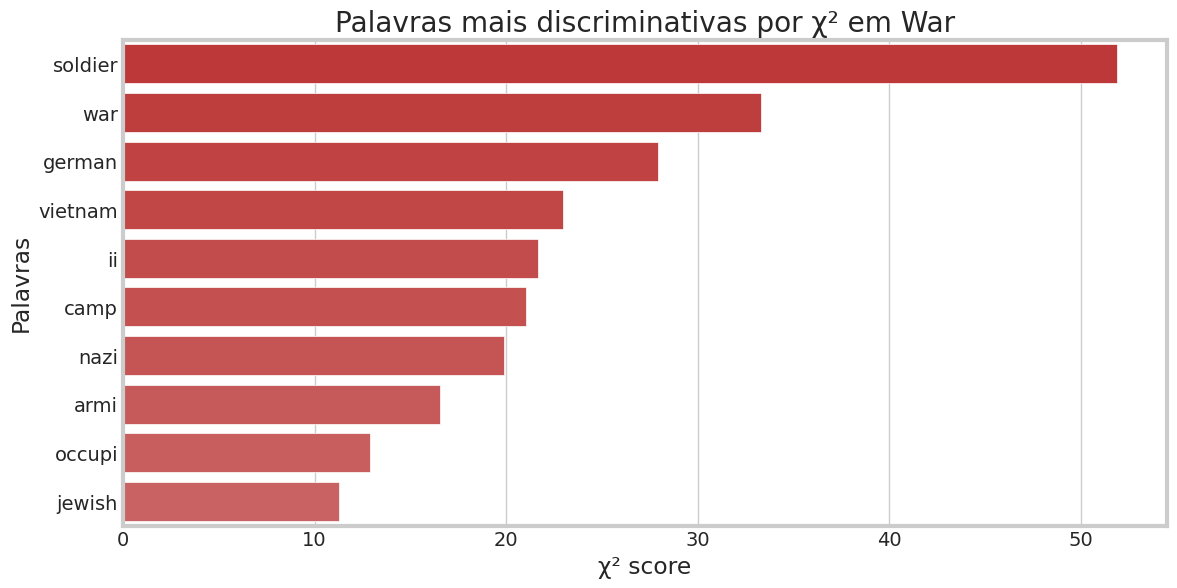

/tmp/ipython-input-1965242625.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Word', x='Chi2', data=df_chi2,
/tmp/ipython-input-1965242625.py:24: UserWarning: The palette list has more values (40) than needed (10), which may not be intended.
  sns.barplot(y='Word', x='Chi2', data=df_chi2,


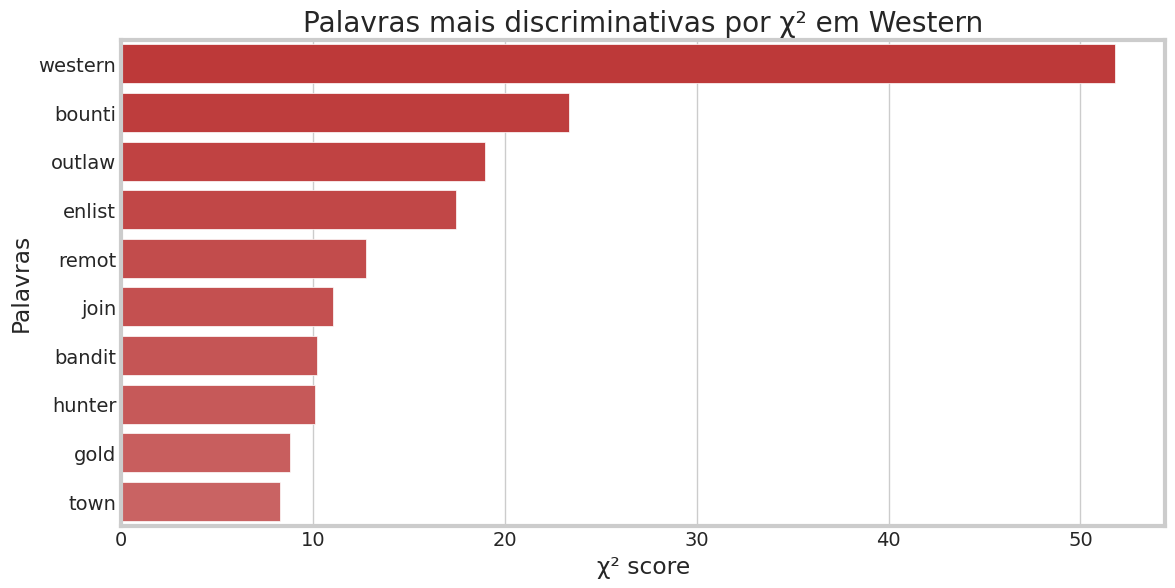

In [148]:
# Aplicar TF-IDF removendo palavras que aparecem em >95% dos documentos e mantendo palavras que aparecem em pelo menos 5 filmes
vectorizer = TfidfVectorizer(max_df=0.95, min_df=5, stop_words='english')
X_tfidf = vectorizer.fit_transform(df_cleaned['Overview'].dropna())
words = vectorizer.get_feature_names_out()

# Loop por gênero
for genre in genres:
    y = df_cleaned[genre].values
    if y.sum() == 0:
        continue

    # Qui-quadrado
    chi2_scores, p_values = chi2(X_tfidf, y)

    # Top 10 palavras discriminativas
    top_idx = chi2_scores.argsort()[-10:][::-1]
    top_words = [words[i] for i in top_idx]
    top_scores = chi2_scores[top_idx]

    df_chi2 = pd.DataFrame({'Word': top_words, 'Chi2': top_scores})

    # Plot
    plt.figure(figsize=(12,6))
    sns.barplot(y='Word', x='Chi2', data=df_chi2,
                palette=sns.light_palette("#d32323", n_colors=40, reverse=True))
    plt.title(f'Palavras mais discriminativas por χ² em {genre}')
    plt.xlabel('χ² score')
    plt.ylabel('Palavras')
    plt.show()

- Respondendo à questão, sim, ao calcular o TF-IDF e o qui-quadrado das palavras presentes nas descrições dos filmes, é possível inferir o seu gênero, pois as 10 palavras mais discriminativas de cada categoria de acordo com o qui-quadrado são bem relacionadas ao gênero.
- Alguns gêneros mais amplos ou com temas variados, como 'Film-Noir', 'Biography' e 'Comedy', apresentam palavras menos diretamente relacionadas em seu top 10. Ainda assim, é possível encontrar termos indicativos do gênero.
- Exemplos:
  - 'Biography': stori, singh, richard, inspir, famous, georg, true, claim, american, final
  - 'Music': rock, pianist, music, band, singer, musician, torn, rise, prepair, director.

# 4. Modelagem

- Nesta seção são apresentadas as etapas de construção, testes e avaliação do modelo preditivo solicitado pelo cliente. Como a variável escolhida como alvo da previsão ('IMDb_Rating') é uma variável numérica contínua, trata-se de um problema de regressão supervisionada, pois os dados disponibilizados já estavam rotulados.
- Para poder comparar o desempenho de diferentes modelos com estes dados, foram escolhidos três tipos de algoritmos de regressão, a regressão linear, florestas aleatórias (ensemble baseado em bagging) e xgboost (ensemble baseado em boosting) [[21]](https://www.geeksforgeeks.org/machine-learning/bagging-vs-boosting-in-machine-learning/). Desta forma, é possível avaliar como estas técnicas diferentes lidam com os dados disponíveis.  
- De acordo com as características da variável alvo detectadas na análise, a métrica principal para avaliação de desempenho do modelo escolhida foi o RMSE (Raiz Quadrada do Erro Médio), pois esta medida penaliza mais os erros. Esta métrica foi escolhida devido à baixa variabilidade dos dados da variável alvo (o mínimo é 7.6 e o máximo 9.2, com desvio-padrão de 0.272) [[22]](https://github.com/LDSSA/batch7-students/blob/main/S01%20-%20Bootcamp%20and%20Binary%20Classification/SLU08%20-%20Metrics%20for%20Regression/Learning%20notebook.ipynb).
- Entretanto, os modelos construídos ao longo desta seção também foram avaliados em outras métricas, como MAE e r², assim, é possível avaliar o desempenho do modelo em erros absolutos e também o quanto da variância que é explicada por ele [[22]](https://github.com/LDSSA/batch7-students/blob/main/S01%20-%20Bootcamp%20and%20Binary%20Classification/SLU08%20-%20Metrics%20for%20Regression/Learning%20notebook.ipynb).

## 4.1 Baseline
- Como abordagem inicial, foram feitos dois testes, um com o máximo de variáveis possíveis e outro apenas com as variáveis numéricas, junto com a avaliação dos coeficientes das variáveis (no caso da regressão linear) e do feature importance (para os algoritmos de random forest e xgboost). Essa avaliação é muito importante para o feature selection e o feature engineering das iterações posteriores.
- Em relação às variáveis, não foram utilizadas:
  - 'Series_Title', 'Director', 'Star1', 'Star2', 'Star3' e 'Star4': estas variáveis possuem muitos valores únicos;
  - 'Overview': pois é uma variável textual, que adiciona complexidade ao modelo e inicialmente optou-se por avaliar apenas as variáveis numéricas e categóricas;
  - 'Genre': Ao longo da limpeza de dados, esta coluna transformada em colunas binárias de cada um dos gêneros disponíveis, então serão utilizadas somente as variáveis resultantes deste processo;
  - 'No_of_Votes': Apesar de ter constatado através das pesquisas que a fórmula do cálculo das notas do IMDb não está disponível para consulta, a quantidade de votos de um filme de alguma maneira é utilizada para o cálculo de sua nota. Então, para evitar o vazamento futuro de dados, esta variável não foi utilizada no treinamento.
  - 'Meta_score': Da mesma forma que o número de votos não será utilizado para evitar vazamento de dados, também foi decidido que esta coluna não seria utilizada, pois trata-se de um sistema similar (não exatamente igual, como nas pesquisas) de avaliação de obras cinematográficas.
- Variáveis disponíveis para construção e testes do modelo:
  - Cada uma das 21 variáveis binárias obtidas a partir da transformação da coluna 'Genre', como 'Drama' e 'Comedy';
  - As variáveis 'Certificate', 'Released_Year', 'Runtime (min)';
  - 'Gross': esta é a única variável que possui dados faltantes e, devido à sua distribuição com cauda à direita, optou-se por preencher os as entradas nulas com a mediana, por representar melhor do que a média.
- A construção de cada modelo foi baseada em pipelines, de acordo com boas práticas de treinamento de algoritmos de aprendizagem de máquina, disponíveis no [tutorial do Lisbon Data Science Academy [23]](https://github.com/LDSSA/batch7-students/blob/main/S01%20-%20Bootcamp%20and%20Binary%20Classification/SLU16%20-%20Workflow/Learning%20notebook.ipynb)
- O uso dos pipelines permite uniformizar e modularizar as transformações das features, separando o pré-processamento da modelagem.
- Além da imputação da mediana nos dados faltantes da variável 'Gross', os dados numéricos foram escalonados com o StandardScaler, pois possuem escalas diferentes (o 'Gross' representa milhões de dólares e o 'Runtime (min)' representa minutos de no máximo 321, por exemplo).
- As variáveis categóricas tiveram duas transformações no seu pipeline, o SimpleImputer (apesar de não haver valores faltantes, ele é aplicado por boas práticas para manter consistência do pipeline) e o OneHotEncoder, que transforma as categorias das variáveis em colunas binárias.
- Os dados foram divididos em treino (60%), validação (20%) e teste (20%), também uma boa prática de treinamento. Para as diferentes iterações da construção do modelo, foram utilizados os dados de validação para avaliação do seu desempenho, apenas quando o melhor modelo for encontrado, os dados de teste serão utilizados.
- Os códigos a seguir são baseados no tutorial [[23]](https://github.com/LDSSA/batch7-students/blob/main/S01%20-%20Bootcamp%20and%20Binary%20Classification/SLU16%20-%20Workflow/Learning%20notebook.ipynb)


In [149]:
# Verificação das colunas disponíveis para o treinamento
df_cleaned.columns

Index(['Series_Title', 'Released_Year', 'Certificate', 'Runtime', 'Genre',
       'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1', 'Star2',
       'Star3', 'Star4', 'No_of_Votes', 'Gross', 'Runtime (min)', 'Genre_list',
       'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War',
       'Western'],
      dtype='object')

In [150]:
# Variável alvo
target = 'IMDB_Rating'

# Lista de todas as variáveis disponíveis
all_features = ['Released_Year', 'Certificate', 'Runtime (min)', 'Gross', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
                'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport',
                'Thriller', 'War', 'Western']

# Separação de variáveis numéricas e categóricas
numerical_features = ['Released_Year', 'Runtime (min)', 'Gross']
categorical_features = ['Certificate', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy',
                        'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War',
                        'Western']

# Pipeline de transformação das variáveis numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Pipeline de transformação das variáveis categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))])

# Pipeline de pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])
pipeline = make_pipeline(preprocessor)

# Separação dos dados
X = df_cleaned[all_features]
y = df_cleaned[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Modelos de regressão
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_split=10, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75)
}

# Lista e dicionário para guardar os resultados
results_baseline = {}
results_list = []

# Treinamento e avaliação do modelo
for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])

    # Treino
    pipe.fit(X_train, y_train)

    # Predição
    y_pred = pipe.predict(X_val)


    # Calcular MAE
    mae = mean_absolute_error(y_val, y_pred)

    # Calcular RMSE
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)

    # Calcular R²
    r2 = r2_score(y_val, y_pred)

    print(f"{name} - MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")

    results_baseline.update({ name: {'MAE': mae, 'RMSE': rmse, 'R2': r2}})
    results_list.append(dict(results_baseline))

    # Obter coeficientes ou feature importance das variáveis
    feature_names = pipe.named_steps["preprocessor"].get_feature_names_out()

    if name == "Linear Regression":
        importances = pipe.named_steps["regressor"].coef_
    elif name in ["Random Forest", "XGBoost"]:
        importances = pipe.named_steps["regressor"].feature_importances_

    if importances is not None:
        importance_df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": importances
        }).sort_values(by="Importance", ascending=False).reset_index(drop=True)

    # Guardar os resultados na lista e no dicionário
    results_baseline[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'Feature_Importance': importance_df
    }
    results_list.append({name: results_baseline[name]})


Linear Regression - MAE: 0.213, RMSE: 0.273, R²: 0.137
Random Forest - MAE: 0.214, RMSE: 0.274, R²: 0.132
XGBoost - MAE: 0.222, RMSE: 0.281, R²: 0.087


In [151]:
# Verificação dos resultados da primeira iteração
results_baseline

{'Linear Regression': {'MAE': 0.21259879079094454,
  'RMSE': np.float64(0.2733418666773771),
  'R2': 0.13659313951796914,
  'Feature_Importance':                       Feature  Importance
  0      cat__Certificate_TV-14    0.315764
  1      cat__Certificate_TV-MA    0.126351
  2         cat__Certificate_16    0.119061
  3                cat__Sport_1    0.064225
  4            cat__Animation_1    0.061520
  5          num__Runtime (min)    0.054784
  6               cat__Sci-Fi_1    0.029534
  7                cat__Crime_1    0.025606
  8                  cat__War_1    0.021951
  9                  num__Gross    0.020599
  10             cat__Mystery_1    0.010972
  11         cat__Certificate_G    0.007909
  12           cat__Biography_1    0.006786
  13               cat__Drama_1    0.004937
  14         cat__Certificate_A   -0.002791
  15             cat__Western_1   -0.004467
  16             cat__Fantasy_1   -0.008568
  17    cat__Certificate_Passed   -0.012926
  18           cat__

- A partir dos resultados da primeira iteração, observou-se que nas métricas de erro, o resultado foi razoável, próximo do desvio-padrão da variável alvo. Entretanto, em relação ao R², os modelos explicam muito pouco a variância (cerca de 13.7% para a regressão linear e 8.7% para o XGBoost).
- O algoritmo que teve o melhor desempenho na métrica principal (RMSE) e no geral foi a regressão linear.
- Ao observar os coeficientes das variáveis, apenas algumas categorias de 'Certificate', 'Runtime (min)' e 'Gross' aparesem positivas. Para o feature importance do random forest, as variáveis numéricas são mais importantes, e para o XGBoost, as variáveis possuem pouca importância, o que explica o baixo desempenho deste algoritmo no R².
- Para a próxima iteração, vão ser utilizadas no modelo apenas as variáveis numéricas.

In [152]:
# Variáveis numéricas
numerical_features = ['Released_Year', 'Runtime (min)', 'Gross']

# Pipeline de transformação das variáveis numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Pipeline de pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features)])

pipeline = make_pipeline(preprocessor)

# Modelos de regressão
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_split=10, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75)
}

# Lista e dicionários para salvar os resultados
results_baseline_num = {}
results_list_num = []

# Treinamento e avaliação do modelo
for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])

    # Treino
    pipe.fit(X_train, y_train)

    # Predição
    y_pred = pipe.predict(X_val)

    # Calcular MAE
    mae = mean_absolute_error(y_val, y_pred)

    # Calcular RMSE
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)

    # Calcular R²
    r2 = r2_score(y_val, y_pred)

    print(f"{name} - MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")

    # Obter coeficientes ou feature importance das variáveis
    results_baseline_num.update({ name: {'MAE': mae, 'RMSE': rmse, 'R2': r2}})
    results_list_num.append(dict(results_baseline_num))

    feature_names_num = pipe.named_steps["preprocessor"].get_feature_names_out()

    if name == "Linear Regression":
        importances = pipe.named_steps["regressor"].coef_
    elif name in ["Random Forest", "XGBoost"]:
        importances = pipe.named_steps["regressor"].feature_importances_

    if importances is not None:
        importance_df = pd.DataFrame({
            "Feature": feature_names_num,
            "Importance": importances
        }).sort_values(by="Importance", ascending=False).reset_index(drop=True)

    # Guardar os resultados na lista e no dicionário
    results_baseline_num[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'Feature_Importance': importance_df
    }
    results_list_num.append({name: results_baseline_num[name]})

Linear Regression - MAE: 0.211, RMSE: 0.272, R²: 0.147
Random Forest - MAE: 0.218, RMSE: 0.284, R²: 0.066
XGBoost - MAE: 0.233, RMSE: 0.311, R²: -0.118


In [153]:
# Verificação dos resultados da segunda iteração
results_baseline_num

{'Linear Regression': {'MAE': 0.21099374228124085,
  'RMSE': np.float64(0.27163662648840686),
  'R2': 0.14733224496160802,
  'Feature_Importance':               Feature  Importance
  0  num__Runtime (min)    0.059959
  1          num__Gross    0.021103
  2  num__Released_Year   -0.044600},
 'Random Forest': {'MAE': 0.2175539882689102,
  'RMSE': np.float64(0.2842583205355471),
  'R2': 0.06625227889329455,
  'Feature_Importance':               Feature  Importance
  0          num__Gross    0.382650
  1  num__Released_Year    0.309954
  2  num__Runtime (min)    0.307397},
 'XGBoost': {'MAE': 0.23315733480453488,
  'RMSE': np.float64(0.3110705396154873),
  'R2': -0.11820376047737913,
  'Feature_Importance':               Feature  Importance
  0          num__Gross    0.384955
  1  num__Runtime (min)    0.332691
  2  num__Released_Year    0.282354}}

- Analisando os resultados da segunda iteração, o melhor modelo da primeira, regressão linear, teve uma performance ligeiramente melhor nas métricas MAE (de 0.213 para 0.211), RMSE (de 0.273 para 0.272) e o R² (de 0.137 para 0.147).
- Os modelos baseados em emsemble (random forest e XGBoost) pioraram o seu desempenho em todas as métricas.
- Apesar destas iterações iniciais terem trazido boas percepções sobre o funcionamento dos algoritmos nestes dados, é necessário tentar outras formas de melhorar o desempenho, por exemplo, através do feature engineering.

## 4.2 Feature Engineering
- Como foi observado na análise, a coluna 'Certificate' possui muitas categorias subrepresentadas. Por isso, optou-se por testar o seu agrupamento, a fim de reduzir o barulho de muitas categorias nos modelos.
- O processo de agrupamento foi igual ao realizado na análise exploratória.
- Também foi adicionada uma variável com a soma de gêneros de cada filme, 'num_genres'.
- Alguns gêneros de filmes também possuem uma baixa representação, então optou-se por manter os 5 mais frequentes e agrupar o restante na coluna 'Other', caso o filme possua outro gênero fora do top 5.
- Além disso, como a distribuição da coluna 'Gross' é muito assimétrica, também foi testado fazer a transformação logarítmica dessa coluna, resultando em 'Gross_log'.
- Assim como na seção de baseline, primeiramente foi testada a construção do modelos com todas as novas variáveis.

In [154]:
# Agrupamento da coluna 'Certificate'
certificate_grouped = pd.value_counts(df_cleaned.Certificate)
mask = (certificate_grouped/certificate_grouped.sum() * 100).lt(10)
df_cleaned['Certificate_grouped'] = np.where(df_cleaned['Certificate'].isin(certificate_grouped[mask].index),'Other',df_cleaned['Certificate'])
df_cleaned['Certificate_grouped'].value_counts()

/tmp/ipython-input-2131152385.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  certificate_grouped = pd.value_counts(df_cleaned.Certificate)


,count
Certificate_grouped,
U,234
A,196
UA,176
R,146
Other,145
unknown,102


In [155]:
df_cleaned['num_genres'] = df_cleaned[genres].sum(axis=1)
df_cleaned['num_genres'].value_counts()

,count
num_genres,
3,646
2,249
1,104


In [156]:
# Ordenar as colunas de gênero pela soma
genre_counts = df_gross[genres].sum().sort_values(ascending=False)

# Definir os gêneros principais (top 5)
top_genres = genre_counts.head(5).index.tolist()

# Criar a coluna 'Other'
df_cleaned['Other'] = df_cleaned[genres].drop(columns=top_genres).max(axis=1)

# Visualizar as transformações
print(df_cleaned[top_genres].sum())
print(df_cleaned['Other'].sum())

Drama        723
Comedy       233
Crime        209
Adventure    196
Action       189
dtype: int64
734


In [157]:
# Transformação logarítmica da coluna 'Gross'
df_cleaned['Gross_log'] = np.log1p(df_cleaned['Gross'])

In [158]:
# Variável alvo
target = 'IMDB_Rating'

# Lista de todas as variáveis disponíveis
all_features = ['Released_Year', 'Certificate', 'Runtime (min)', 'Gross_log', 'Action', 'Adventure', 'Comedy', 'Crime',
                'Drama', 'num_genres', 'Certificate_grouped', 'Other']

# Separação de variáveis numéricas e categóricas
numerical_features = ['Released_Year', 'Runtime (min)', 'Gross_log', 'num_genres']
categorical_features = ['Certificate_grouped', 'Action', 'Adventure', 'Comedy', 'Crime', 'Drama']

# Pipeline de transformação das variáveis numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Pipeline de transformação das variáveis categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))])

# Pipeline de pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = make_pipeline(preprocessor)

# Separação dos dados
X = df_cleaned[all_features]
y = df_cleaned[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Modelos de regressão
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_split=10, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75)
}

# Lista e dicionário para guardar os resultados
results_baseline_fe = {}
results_list_fe = []

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])

    # Treino
    pipe.fit(X_train, y_train)

    # Predição
    y_pred = pipe.predict(X_val)

    # Calcular MAE
    mae = mean_absolute_error(y_val, y_pred)

    # Calcular RMSE
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)

    # Calcular R²
    r2 = r2_score(y_val, y_pred)

    print(f"{name} - MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")

    # Obter coeficientes ou feature importance das variáveis
    results_baseline_fe.update({ name: {'MAE': mae, 'RMSE': rmse, 'R2': r2}})
    results_list_fe.append(dict(results_baseline_fe))

    feature_names_fe = pipe.named_steps["preprocessor"].get_feature_names_out()

    if name == "Linear Regression":
        importances = pipe.named_steps["regressor"].coef_
    elif name in ["Random Forest", "XGBoost"]:
        importances = pipe.named_steps["regressor"].feature_importances_

    if importances is not None:
        importance_df = pd.DataFrame({
            "Feature": feature_names_fe,
            "Importance": importances
        }).sort_values(by="Importance", ascending=False).reset_index(drop=True)

    # Guardar os resultados na lista e no dicionário
    results_baseline_fe[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'Feature_Importance': importance_df
    }
    results_list_fe.append({name: results_baseline_fe[name]})


Linear Regression - MAE: 0.212, RMSE: 0.273, R²: 0.140
Random Forest - MAE: 0.212, RMSE: 0.275, R²: 0.123
XGBoost - MAE: 0.220, RMSE: 0.287, R²: 0.049


In [159]:
results_baseline_fe

{'Linear Regression': {'MAE': 0.21213652963885252,
  'RMSE': np.float64(0.2728041400889462),
  'R2': 0.139986839585035,
  'Feature_Importance':                              Feature  Importance
  0                 num__Runtime (min)    0.054215
  1         cat__Certificate_grouped_A    0.052124
  2                   cat__Adventure_1    0.035715
  3                       cat__Crime_1    0.032508
  4        cat__Certificate_grouped_UA    0.028302
  5         cat__Certificate_grouped_U    0.027531
  6                       cat__Drama_1    0.016847
  7     cat__Certificate_grouped_Other   -0.009709
  8                    num__num_genres   -0.010183
  9                      cat__Action_1   -0.010839
  10                    num__Gross_log   -0.015331
  11                     cat__Comedy_1   -0.025193
  12  cat__Certificate_grouped_unknown   -0.035582
  13                num__Released_Year   -0.040381
  14        cat__Certificate_grouped_R   -0.062667},
 'Random Forest': {'MAE': 0.212484068538

- Com a introdução de novas variáveis transformadas, o desempenho do modelo de regressão linear foi ligeiramente pior nas métricas: MAE (de 0.211 a 0.212), no RMSE (de 0.272 a 0.273) e no R² (de 0.147 a 0.140).
- Para os outros modelos, o desempenho foi melhor, mas ainda abaixo da regressão linear.
- De acordo com os coeficientes da regressão linear, a coluna 'Gross_log' possui um índice menor do que 'Gross'. 'num_genres' também não adicionou muita informação ao modelo.
- Para a próxima iteração, outras combinações de variáveis serão testadas.

In [160]:
# Agrupamento da coluna 'Certificate' (top 3)
certificate_grouped = pd.value_counts(df_cleaned.Certificate)
mask = (certificate_grouped/certificate_grouped.sum() * 100).lt(15)
df_cleaned['Certificate_grouped'] = np.where(df_cleaned['Certificate'].isin(certificate_grouped[mask].index),'Other',df_cleaned['Certificate'])
df_cleaned['Certificate_grouped'].value_counts()

/tmp/ipython-input-3953184345.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  certificate_grouped = pd.value_counts(df_cleaned.Certificate)


,count
Certificate_grouped,
Other,393
U,234
A,196
UA,176


In [161]:
# Ordenar as colunas de gênero pela soma
genre_counts = df_cleaned[genres].sum().sort_values(ascending=False)

# Definir o gênero principal
top_genres = genre_counts.head(1).index.tolist()

# Criar a coluna "Other"
df_cleaned['Other'] = df_cleaned[genres].drop(columns=top_genres).max(axis=1)

# Visualizar as transformações
print(df_cleaned[top_genres].sum())
print(df_cleaned['Other'].sum())

Drama    723
dtype: int64
915


In [162]:
# Variável alvo
target = 'IMDB_Rating'

# Lista de todas as variáveis disponíveis
all_features = ['Released_Year', 'Runtime (min)', 'Gross', 'Drama', 'Certificate_grouped', 'Other']

# Separação das colunas numéricas e categóricas
numerical_features = ['Released_Year', 'Runtime (min)', 'Gross']
categorical_features = ['Certificate_grouped', 'Drama', 'Other']

# Pipeline de transformação das variáveis numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Pipeline de transformação das variáveis categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))])

# Pipeline de pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = make_pipeline(preprocessor)

# Separação dos dados
X = df_cleaned[all_features]
y = df_cleaned[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Modelos de regressão linear
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_split=10, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75)
}

# Lista e dicionário para guardar os resultados
results_fe2 = {}
results_list_fe2 = []

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])

    # Treino
    pipe.fit(X_train, y_train)

    # Predição
    y_pred = pipe.predict(X_val)

    # Calcular MAE
    mae = mean_absolute_error(y_val, y_pred)

    # Calcular RMSE
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)

    # Calcular R²
    r2 = r2_score(y_val, y_pred)

    print(f"{name} - MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")


    results_fe2.update({ name: {'MAE': mae, 'RMSE': rmse, 'R2': r2}})
    results_list_fe2.append(dict(results_fe2))

    # Obter coeficientes ou feature importance das variáveis
    feature_names_fe2 = pipe.named_steps["preprocessor"].get_feature_names_out()

    if name == "Linear Regression":
        importances = pipe.named_steps["regressor"].coef_
    elif name in ["Random Forest", "XGBoost"]:
        importances = pipe.named_steps["regressor"].feature_importances_

    if importances is not None:
        importance_df = pd.DataFrame({
            "Feature": feature_names_fe2,
            "Importance": importances
        }).sort_values(by="Importance", ascending=False).reset_index(drop=True)

    # Guardar os resultados na lista e no dicionário
    results_fe2[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'Feature_Importance': importance_df
    }
    results_list_fe2.append({name: results_fe2[name]})

Linear Regression - MAE: 0.209, RMSE: 0.269, R²: 0.165
Random Forest - MAE: 0.213, RMSE: 0.275, R²: 0.124
XGBoost - MAE: 0.224, RMSE: 0.294, R²: 0.001


In [163]:
results_fe2

{'Linear Regression': {'MAE': 0.20871131741673046,
  'RMSE': np.float64(0.2688808712628517),
  'R2': 0.164545126524565,
  'Feature_Importance':                           Feature  Importance
  0              num__Runtime (min)    0.052339
  1      cat__Certificate_grouped_A    0.037552
  2                    cat__Drama_1    0.031983
  3                      num__Gross    0.021119
  4      cat__Certificate_grouped_U    0.004447
  5     cat__Certificate_grouped_UA    0.004142
  6                    cat__Other_1   -0.013807
  7  cat__Certificate_grouped_Other   -0.046141
  8              num__Released_Year   -0.051738},
 'Random Forest': {'MAE': 0.21257677719621498,
  'RMSE': np.float64(0.27527299324867227),
  'R2': 0.12435031880276903,
  'Feature_Importance':                           Feature  Importance
  0                      num__Gross    0.313223
  1              num__Released_Year    0.279396
  2              num__Runtime (min)    0.271252
  3      cat__Certificate_grouped_A    0.04

- Nesta quarta iteração, foram obtidos resultados melhores para a regressão linear: a MAE caiu para 0.209, o RMSE, para 0.269 e R² para 0.147.
- Este é o melhor resultado para este algoritmo entre todas as tentativas. Foi utilizada a variável 'Gross' no seu formato original, apenas duas colunas de gênero, 'Drama' e 'Other' e foi realizado um agrupamento maior da coluna 'Certificate', com apenas três categorias e o 'Other'.
- Os outros modelos não obtiveram desempenhos expressivos.

### Conclusões sobre a modelagem
- Apesar do desempenho da regressão linear ser superior ao dos modelos de ensemble, ainda não são resultados satisfatórios. As variáveis, mesmo com algumas técnicas de feature engineering, não conseguem explicar as notas do IMDb.
- A falta de variação da variável alvo identificada na análise exploratória é um fator limitante no desempenho dos modelos preditivos.
- A orientação principal neste caso seria conseguir mais dados com maior abrangência das notas do IMDb dos filmes, para que o modelo seja mais robusto. Como mencionado anteriormente, os dados da variável alvo, são pouco abrangentes e limitam o desempenho dos algoritmos.
- Como o IMDb disponibiliza os seus dados, é possível obtê-los através de técnicas como o web scraping.
- Além das técnicas utilizadas, ainda seria possível fazer um ajuste de hiperparâmetros dos modelos de ensemble, aplicar regularização na regressão linear e até mesmo testar outros algoritmos, como SVR e KNN (mais simples) ou redes neurais e LSTM (mais complexos).

# 5. Preparaçao do modelo, serialização e teste com entrada sugerida
- Com o melhor modelo definido, a próxima etapa é avaliar com os dados de teste.
- Antes deste teste, como todas as etapas de limpeza e transformações de dados já estão definidas, para obter reprodutibilidade e consistência nestes processos, foi criado um pipeline customizado, CleanDataTransformer(). Os dados serão carregados novamente para testar este pipeline, bem como realizar o treinamento nos dados de validação para comprovar o funcionamento do pipeline.
- O código a seguir foi adaptado do tutorial de [pipelines avançados do Lisbon Data Science Academy [24]](https://github.com/LDSSA/batch7-students/blob/main/S02%20-%20Data%20Wrangling/BLU02%20-%20Advanced%20Wrangling/Learning%20notebook%20-%20Part%203%20of%203%20-%20Advanced%20pipelines.ipynb).

In [164]:
# Criar pipeline de transformação com todas as etapas de limpeza e transformação de dados
class CleanDataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, top_genres_n=1, certificate_threshold=15):
        self.top_genres_n = top_genres_n
        self.certificate_threshold = certificate_threshold
        self.mlb = None
        self.top_genres = None
        self.certificate_map = None

    def fit(self, X, y=None):
        X_copy = X.copy()

        # 'Gender'
        X_copy["Genre_list"] = X_copy['Genre'].str.split(", ")
        self.mlb = MultiLabelBinarizer()
        genre_matrix = self.mlb.fit_transform(X_copy["Genre_list"])
        self.top_genres = pd.DataFrame(genre_matrix, columns=self.mlb.classes_).sum().sort_values(ascending=False).head(self.top_genres_n).index.tolist()

        # 'Certificate'
        X_copy['Certificate']=X_copy['Certificate'].replace({'GP':'PG', 'U/A':'UA', 'Unrated':'unknown'})
        X_copy['Certificate']=X_copy['Certificate'].fillna('unknown')
        certificate_counts = X_copy['Certificate'].value_counts()
        mask = (certificate_counts / certificate_counts.sum() * 100).lt(self.certificate_threshold)
        self.certificate_map = {k:'Other' for k in certificate_counts[mask].index}

        return self

    def transform(self, X):
        X_copy = X.copy()

        # 'Released_Year'
        X_copy['Released_Year'] = X_copy['Released_Year'].replace('PG', '1995').astype(int)

        # 'Runtime (min)'
        X_copy['Runtime (min)'] = X_copy['Runtime'].str.replace(' min', '').astype(int)

        # 'Gross'
        X_copy['Gross'] = X_copy['Gross'].str.replace('$','').str.replace(',','').astype(float)

        # 'Genre'
        X_copy["Genre_list"] = X_copy['Genre'].str.split(", ")
        genre_matrix = self.mlb.transform(X_copy["Genre_list"])
        df_genres = pd.DataFrame(genre_matrix, columns=self.mlb.classes_, index=X_copy.index)
        X_copy = pd.concat([X_copy, df_genres], axis=1)

        # Criar coluna 'Other'
        X_copy['Other'] = df_genres.drop(columns=self.top_genres, errors='ignore').max(axis=1)

        # 'Certificate'
        X_copy['Certificate']=X_copy['Certificate'].replace({'GP':'PG', 'U/A':'UA', 'Unrated':'unknown'})
        X_copy['Certificate']=X_copy['Certificate'].fillna('unknown')
        X_copy['Certificate_grouped'] = X_copy['Certificate'].replace(self.certificate_map)

        # Remover colunas não necessárias
        drop_cols = ['Unnamed: 0', 'Series_Title', 'Overview', 'Meta_score', 'Director', 'Star1', 'Star2', 'Star3', 'Star4',
                     'No_of_Votes', 'Genre', 'Genre_list', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
                     'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport',
                     'Thriller', 'War', 'Western', 'Certificate', 'Runtime']
        X_copy = X_copy.drop(columns=[col for col in drop_cols if col in X_copy.columns])

        return X_copy

In [165]:
# Carregar os dados novamente
df = pd.read_csv('desafio_indicium_imdb.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


In [166]:
# Variável alvo
target = 'IMDB_Rating'

# Pipeline de limpeza e transformações de dados
cleaner = CleanDataTransformer(top_genres_n=1, certificate_threshold=15)

# Pipeline de transformação das variáveis numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Pipeline de transformação das variáveis categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))])

# Pipeline de pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, make_column_selector(dtype_include=np.number)),
        ('cat', categorical_transformer, make_column_selector(dtype_exclude=np.number))])

# Separação dos dados
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Modelo de regressão
model = LinearRegression()

# Lista e dicionário para guardar os resultados
results_final_val = {}
results_list_final_val = []

# Pipeline final
pipe = Pipeline(steps=[
    ('cleaner', CleanDataTransformer(top_genres_n=1, certificate_threshold=15)),
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Treino
pipe.fit(X_train, y_train)

# Predição
y_pred = pipe.predict(X_val)

# Métricas
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f"Linear Regression - MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")

# Obter os coeficientes das variáveis
feature_names = pipe.named_steps["preprocessor"].get_feature_names_out()
importances = pipe.named_steps["regressor"].coef_

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).reset_index(drop=True)

 # Guardar os resultados na lista e no dicionário
results_final_val["Linear Regression"] = {
    'MAE': mae,
    'RMSE': rmse,
    'R2': r2,
    'Feature_Importance': importance_df
}
results_list_final_val.append({ "Linear Regression": results_final_val["Linear Regression"] })


Linear Regression - MAE: 0.209, RMSE: 0.269, R²: 0.162


In [167]:
results_final_val

{'Linear Regression': {'MAE': 0.20908708296520218,
  'RMSE': np.float64(0.26934114344522153),
  'R2': 0.16168240324975225,
  'Feature_Importance':                           Feature  Importance
  0              num__Runtime (min)    0.053063
  1      cat__Certificate_grouped_A    0.047624
  2                      num__Gross    0.020804
  3      cat__Certificate_grouped_U    0.015658
  4                      num__Drama    0.015238
  5     cat__Certificate_grouped_UA    0.011663
  6                      num__Other   -0.003893
  7  cat__Certificate_grouped_Other   -0.020192
  8              num__Released_Year   -0.047103
  9      cat__Certificate_grouped_R   -0.054753}}

- Após a conferir o funcionamento do pipeline, o modelo é testado nos dados de teste.

In [168]:
# Lista e dicionário para guardar os resultados
results_final_test = {}
results_list_final_test = []

# Predição
y_pred = pipe.predict(X_test)

# Métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression - MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")

# Obter coeficientes das variáveis
feature_names = pipe.named_steps["preprocessor"].get_feature_names_out()
importances = pipe.named_steps["regressor"].coef_

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).reset_index(drop=True)

# Guardar os resultados na lista e no dicionário
results_final_test["Linear Regression"] = {
    'MAE': mae,
    'RMSE': rmse,
    'R2': r2,
    'Feature_Importance': importance_df
}
results_list_final_test.append({ "Linear Regression": results_final_test["Linear Regression"] })

Linear Regression - MAE: 0.196, RMSE: 0.240, R²: 0.123


In [169]:
results_list_final_test

[{'Linear Regression': {'MAE': 0.19646048195039467,
   'RMSE': np.float64(0.2399299695462065),
   'R2': 0.12305175969710025,
   'Feature_Importance':                           Feature  Importance
   0              num__Runtime (min)    0.053063
   1      cat__Certificate_grouped_A    0.047624
   2                      num__Gross    0.020804
   3      cat__Certificate_grouped_U    0.015658
   4                      num__Drama    0.015238
   5     cat__Certificate_grouped_UA    0.011663
   6                      num__Other   -0.003893
   7  cat__Certificate_grouped_Other   -0.020192
   8              num__Released_Year   -0.047103
   9      cat__Certificate_grouped_R   -0.054753}}]

- Comparando os resultados do modelo com os dados de validação e dados de teste, o desempenho nas variáveis MAE e RMSE foram melhores (de 0.209 para 0.196 e de 0.269 para 0.240, respectivamente). Entretanto, para o R², o desempenho piorou (de 0.162 para 0.123).
- Os coeficientes das variáveis são os mesmos.

- Depois do treinamento, acontece a serialização, que é o processo de armazenar o estado de um objeto para que ele possa ser usado mais tarde [[25]](https://github.com/LDSSA/railway-model-deploy/blob/main/Learning%20notebook%20-%20Part%201%20of%202%20-%20Train%20and%20serialize.ipynb).
- Em seguida, o modelo é carregado novamente e testado com a entrada sugerida nos requisitos deste projeto.


In [170]:
# Serializar o modelo
joblib.dump(pipe, 'pipeline.pkl');

In [171]:
# Carrega pipeline
pipe = joblib.load('pipeline.pkl')

# Teste com entrada sugerida
new_data = pd.DataFrame([{
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': '1994',
    'Certificate': 'A',
    'Runtime': '142 min',
    'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': '28,341,469'
}])

# Predição
y_pred_new_data = pipe.predict(new_data)
print(y_pred_new_data)

[8.0490011]


- Para esta entrada, o modelo sugeriu o valor de 8.049 para a nota do IMDb do filme, entretanto, sua pontuação real é 9.3 [[26]](https://www.imdb.com/title/tt0111161/).
- A diferença é de 1.25 pontos, o que evidencia ainda mais as conclusões feitas a partir da modelagem, pois esta nota é mais alta do que o máximo presente nos dados analisados neste projeto (9.2).

# 6. Conclusões Gerais
- Ao longo deste projeto, para atender aos requisitos do cliente, foram utilizadas várias técnicas de ciência de dados, como limpeza de dados, análise estatística descritiva, inferencial, visualização de dados, técnicas de NLP (TF-IDF, tokenização, etc), modelagem preditiva, feature selection e feature engineering. Também foram feitas pesquisa de fontes externas para um melhor entendimento dos dados cinematográficos oferecidos.
- Em resumo a análise proporcionou compreender as variáveis e suas relações, bem como responder questões de negócio.
- Os pontos principais da análise exploratória foram:
  - Identificação das características do mercado cinematográfico:
  - Duração dos filmes ser entre 100 e 140 minutos, majoritariamente;
  - Tendência de crescimento de produções e de engajamento nas últimas décadas;
  - Distribuição assimétrica dos rendimentos, inicando que apenas poucos filmes possuem os maiores lucros;
  - Classificações indicativas mais gerais, como 'U', 'UA' e 'A', ao invés de categorias com restrições de idade específicas, são mais comuns e possuem um alto rendimento médio:
  - Relações entre o gênero do filme e sua descrição, com a presença de palavras relacionadas à sua categoria, também relação do gênero com o engajamento, rendimento e avaliação crítica.
- Na seção de modelagem, mesmo com as limitações do conjunto de dados, foi construído um modelo preditivo de regressão com RMSE e MAE relativamente baixos.
- Este modelo representa uma base sólida para futuros retreinamentos com conjuntos de dados mais representativos, podendo assim, apoiar cada vez mais as decisões do estúdio PProduction na previsão de avaliações do IMDb.